In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import mglearn
import sklearn
import sklearn.datasets
from numpy import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report
from sklearn.model_selection import cross_val_score, ShuffleSplit

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap

from string import ascii_letters
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
y_valid = pd.read_csv("y_valid_Mo1.csv", sep='\t', index_col=0)
X_valid_selected = pd.read_csv("X_valid_selected_Mo1.csv", sep='\t', index_col=0)
y_valid_next = pd.read_csv("y_valid_next_Mo1.csv", sep='\t', index_col=0)
X_valid_next_selected = pd.read_csv("X_valid_next_selected_Mo1.csv", sep='\t', index_col=0)
X_traintest_selected = pd.read_csv("X_traintest_selected_Mo1.csv", sep='\t', index_col=0)
y_traintest_sampled = pd.read_csv("y_traintest_sampled_Mo1.csv", sep='\t', index_col=0)

In [3]:
shap_values_xgb_Mo1_traintest = pd.read_csv("df_shap_values_xgb_Mo1_traintest.csv", sep='\t', index_col=0)
shap_values_xgb_Mo1_valid = pd.read_csv("df_shap_values_xgb_Mo1_valid.csv", sep='\t', index_col=0)
shap_values_xgb_Mo1_valid_next = pd.read_csv("df_shap_values_xgb_Mo1_valid_next.csv", sep='\t', index_col=0)

In [4]:
X_valid_next_selected.head()

,C_028,C_048,C_083,C_096,C_142,C_210,C_224,C_268,C_287,C_326,...,N_046,N_063,N_130,N_136,N_138,N_141,N_143,N_148,N_152,N_153
0,0.100,0.146,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,0.162,0.162,0.158,0.124,0.122,0.124,0.179,0.166,0.143,0.999
1,0.102,0.146,0.1,0.1,0.102,0.101,0.102,0.1,0.1,0.102,...,0.167,0.167,0.158,0.124,0.122,0.124,0.179,0.166,0.143,0.999
2,0.124,0.146,0.1,0.1,0.102,0.101,0.102,0.1,0.1,0.102,...,0.168,0.168,0.158,0.124,0.122,0.124,0.179,0.166,0.143,0.175
3,0.100,0.100,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,0.170,0.170,0.158,0.124,0.122,0.124,0.179,0.166,0.143,0.173
4,0.102,0.100,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,0.170,0.170,0.158,0.124,0.122,0.124,0.179,0.166,0.143,0.999


In [5]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['TP', 'Not TP']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, clf.predict(X_valid)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [6]:
def evaluate_scores(X_valid, y_valid, clf):
    print("AUC score: {:.3f}".format(roc_auc_score(y_valid, clf.predict(X_valid))))
    print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, clf.predict(X_valid))))
    print("F1-micro score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="micro")))
#     print("F1-weighted score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="weighted")))
    print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_valid, clf.predict(X_valid))))
    print(classification_report(y_valid, clf.predict(X_valid)))

In [7]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)
xgb_valid_next = xgboost.DMatrix(X_valid_next_selected, label=y_valid_next)
X_all = pd.concat((X_traintest_selected, X_valid_selected)).reset_index(drop=True)
y_traintest_sampled.columns =['fraud_label']
y_all = pd.concat((y_traintest_sampled, y_valid)).reset_index(drop=True)
xgb_all = xgboost.DMatrix(X_all, label=y_all)

In [8]:
# use validation set to choose # of trees
params = {'max_depth':9, 'n_estimators':100,
#           'objective': 'multi:softmax', 'num_class': 2,
                  'objective': "binary:logistic",
          'early_stopping_rounds':10,
          'min_child_weight': 7,
          'subsample': 1.0,
          'colsample_bytree': 0.7,
          'learning_rate': 0.1,
#           'gamma': 0.1
}
params_proba = {'max_depth':9, 'n_estimators':100,
#           'objective': 'multi:softprob', 'num_class': 2,
                  'objective': "binary:logistic",
          'early_stopping_rounds':10,
          'min_child_weight': 7,
          'subsample': 1.0,
          'colsample_bytree': 0.7,
          'learning_rate': 0.1,
#           'gamma': 0.1
}

In [9]:
# tmp_traintest.iloc[:, 45:67].head()
# xgb_traintest_rank = xgboost.DMatrix(tmp_traintest.iloc[:, 45:67], label=y_traintest_sampled)
# xgb_valid_rank = xgboost.DMatrix(tmp_valid.iloc[:, 45:67], label=y_valid)
# xgb_valid_next_rank = xgboost.DMatrix(tmp_valid_next.iloc[:, 45:67], label=y_valid_next)

# xgb_rank = xgboost.train(params, xgb_valid_rank, 100)
# xgb_rank_pred = xgb_rank.predict(xgb_valid_next_rank)

# evaluate_scores(xgb_valid_next_rank, y_valid_next, xgb_rank)

In [10]:
xgb = xgboost.train(params, xgb_traintest, 100)
xgb_proba = xgboost.train(params_proba, xgb_traintest, 100)

In [11]:
xgb_pred = xgb.predict(xgb_valid)

In [12]:
print("AUC score: {:.3f}".format(roc_auc_score(y_traintest_sampled, xgb.predict(xgb_traintest))))
print("AUC score: {:.3f}".format(roc_auc_score(y_valid, xgb.predict(xgb_valid))))
print("AUC score: {:.3f}".format(roc_auc_score(y_valid_next, xgb.predict(xgb_valid_next))))

AUC score: 0.997
AUC score: 0.993
AUC score: 0.995


In [13]:
y_traintest_sampled['fraud_label'].value_counts()

0    39894
1     1656
Name: fraud_label, dtype: int64

In [176]:
y_valid['fraud_label'].value_counts()

0    598069
1       409
Name: fraud_label, dtype: int64

In [14]:
xgb_pred_traintest = np.where(xgb.predict(xgb_traintest)>0.5, 1, 0)
confusion_matrix(y_traintest_sampled, xgb_pred_traintest)

array([[39774,   120],
       [  199,  1457]])

In [15]:
xgb_pred_valid = np.where(xgb.predict(xgb_valid)>0.5, 1, 0)
confusion_matrix(y_valid, xgb_pred_valid)

array([[595437,   2632],
       [    64,    345]])

In [16]:
xgb_pred_valid_next = np.where(xgb.predict(xgb_valid_next)>0.5, 1, 0)
confusion_matrix(y_valid_next, xgb_pred_valid_next)

array([[144157,    597],
       [    31,    157]])

In [17]:
### logistic
xgb_Mo1_pred_traintest = np.where(xgb.predict(xgb_traintest)>0.5, 1, 0)
xgb_Mo1_pred_valid = np.where(xgb.predict(xgb_valid)>0.5, 1, 0)
xgb_Mo1_pred_valid_next = np.where(xgb.predict(xgb_valid_next)>0.5, 1, 0)

xgb_Mo1_pred_proba_traintest = xgb.predict(xgb_traintest)
xgb_Mo1_pred_proba_valid = xgb.predict(xgb_valid)
xgb_Mo1_pred_proba_valid_next = xgb.predict(xgb_valid_next)

In [18]:
### softmax
# xgb_Mo1_pred_traintest = xgb.predict(xgb_traintest)
# xgb_Mo1_pred_valid = xgb.predict(xgb_valid)
# xgb_Mo1_pred_valid_next = xgb.predict(xgb_valid_next)
# xgb_Mo1_pred_proba_traintest = xgb_proba.predict(xgb_traintest)[:, 1]
# xgb_Mo1_pred_proba_valid = xgb_proba.predict(xgb_valid)[:, 1]
# xgb_Mo1_pred_proba_valid_next = xgb_proba.predict(xgb_valid_next)[:, 1]

In [19]:
# evaluate_scores(xgb_valid_next, y_valid_next, xgb)

In [20]:
# confusion_matrix_plot(xgb_valid_next, y_valid_next, xgb)

In [21]:
df_predict_ori_traintest = pd.DataFrame(xgb_Mo1_pred_traintest, columns=['predict_ori'])
df_predict_ori_valid = pd.DataFrame(xgb_Mo1_pred_valid, columns=['predict_ori'])
df_predict_ori_valid_next = pd.DataFrame(xgb_Mo1_pred_valid_next, columns=['predict_ori'])

In [22]:
df_predict_proba_traintest = pd.DataFrame(xgb_Mo1_pred_proba_traintest, columns=['predict_proba'])
df_predict_proba_valid = pd.DataFrame(xgb_Mo1_pred_proba_valid, columns=['predict_proba'])
df_predict_proba_valid_next = pd.DataFrame(xgb_Mo1_pred_proba_valid_next, columns=['predict_proba'])

In [23]:
df_predict_ori_traintest = df_predict_ori_traintest.join(df_predict_proba_traintest)
df_predict_ori_valid = df_predict_ori_valid.join(df_predict_proba_valid)
df_predict_ori_valid_next = df_predict_ori_valid_next.join(df_predict_proba_valid_next)

### Compute SHAP value

In [24]:
explainer = shap.TreeExplainer(xgb)
shap_values_xgb_Mo1_traintest = explainer.shap_values(X_traintest_selected)
shap_values_xgb_Mo1_valid = explainer.shap_values(X_valid_selected)

# shap_values_xgb_Mo1_traintest = xgb.predict(xgb_traintest, pred_contribs=True)
# shap_values_xgb_Mo1_valid = xgb.predict(xgb_valid, pred_contribs=True)
# shap_values_xgb_Mo1_valid_next = xgb.predict(xgb_valid_next, pred_contribs=True)

In [26]:
shap_values_xgb_Mo1_valid_next = explainer.shap_values(X_valid_next_selected)

In [31]:
df_shap_values_xgb_Mo1_traintest = pd.DataFrame(shap_values_xgb_Mo1_traintest, columns = list(X_traintest_selected)+['bias'])
df_shap_values_xgb_Mo1_valid = pd.DataFrame(shap_values_xgb_Mo1_valid, columns = list(X_traintest_selected)+['bias'])
df_shap_values_xgb_Mo1_valid_next = pd.DataFrame(shap_values_xgb_Mo1_valid_next, columns = list(X_traintest_selected)+['bias'])

In [32]:
df_shap_values_xgb_Mo1_traintest.columns = [str(col) + '_SHAP' for col in df_shap_values_xgb_Mo1_traintest.columns]
df_shap_values_xgb_Mo1_valid.columns = [str(col) + '_SHAP' for col in df_shap_values_xgb_Mo1_valid.columns]
df_shap_values_xgb_Mo1_valid_next.columns = [str(col) + '_SHAP' for col in df_shap_values_xgb_Mo1_valid_next.columns]

In [33]:
# df_shap_values_xgb_Mo1_traintest.to_csv("df_shap_values_xgb_Mo1_traintest.csv", sep='\t')
# df_shap_values_xgb_Mo1_valid.to_csv("df_shap_values_xgb_Mo1_valid.csv", sep='\t')
# df_shap_values_xgb_Mo1_valid_next.to_csv("df_shap_values_xgb_Mo1_valid_next.csv", sep='\t')

In [26]:
# df_shap_values_xgb_Mo1_traintest = shap_values_xgb_Mo1_traintest
# df_shap_values_xgb_Mo1_valid = shap_values_xgb_Mo1_valid
# df_shap_values_xgb_Mo1_valid_next = shap_values_xgb_Mo1_valid_next

### Append extra SHAP features

In [34]:
shap_traintest = df_shap_values_xgb_Mo1_traintest.copy()
shap_valid = df_shap_values_xgb_Mo1_valid.copy()
shap_valid_next = df_shap_values_xgb_Mo1_valid_next.copy()

In [35]:
def append_features(shap_value):
    rank = shap_value.iloc[:, 0:22].abs().rank(1, ascending=False, method='first').astype(int)
    rank.columns = [str(col) + '_rank' for col in rank.columns]
    tmp = shap_value.join(rank)
    tmp['prob'] = shap_value.iloc[:, 0:23].sum(axis=1)
    tmp['sum'] = shap_value.iloc[:, 0:22].sum(axis=1)
    tmp['sum_abs'] = shap_value.iloc[:, 0:22].abs().sum(axis=1)
    tmp['var'] = shap_value.iloc[:, 0:22].abs().var(axis=1)
#     tmp['disp'] = shap_value['var'] / shap_value.iloc[:, 0:22].mean(axis=1)   
#     tmp['sum_pos'] = shap_value[shap_value.iloc[:, 0:22].gt(0, axis=1)].sum(axis=1)
#     tmp['sum_neg'] = shap_value[shap_value.iloc[:, 0:22].le(0, axis=1)].sum(axis=1)   
#     tmp['C_224_SHAP+C_083_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP']
#     tmp['C_224_SHAP+C_048_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_048_SHAP']
#     tmp['C_224_SHAP+C_048_SHAP+C_096_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_048_SHAP'] + shap_value['C_096_SHAP']

#     tmp['C_224_SHAP+C_083_SHAP+N_045_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP']
#     tmp['C_224_SHAP+C_083_SHAP+N_046_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_046_SHAP']
#     tmp['C_224_SHAP+C_083_SHAP+N_045_SHAP+N_143_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP'] + shap_value['N_143_SHAP']
#     tmp['C_224_SHAP+C_083_SHAP+N_045_SHAP+C_357_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP'] + shap_value['C_357_SHAP']
#     tmp['C_224_SHAP+C_083_SHAP+N_045_SHAP+C_357_SHAP+N_143_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP'] + shap_value['C_357_SHAP'] + shap_value['N_143_SHAP']
#     tmp['C_224_SHAP+C_083_SHAP+N_045_SHAP+N_143_SHAP+N_046_SHAP'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP'] + shap_value['N_143_SHAP'] + shap_value['N_046_SHAP']
    return tmp

In [36]:
tmp = append_features(shap_traintest)
tmp1 = X_traintest_selected.join(tmp)
tmp2 = tmp1.join(y_traintest_sampled)
tmp_traintest = tmp2.join(df_predict_ori_traintest)

tmp = append_features(shap_valid)
tmp1 = X_valid_selected.join(tmp)
tmp2 = tmp1.join(y_valid)
tmp_valid = tmp2.join(df_predict_ori_valid)

tmp = append_features(shap_valid_next)
tmp1 = X_valid_next_selected.join(tmp)
tmp2 = tmp1.join(y_valid_next)
tmp_valid_next = tmp2.join(df_predict_ori_valid_next)

In [37]:
tmp_valid_next.head()

,C_028,C_048,C_083,C_096,C_142,C_210,C_224,C_268,C_287,C_326,...,N_148_SHAP_rank,N_152_SHAP_rank,N_153_SHAP_rank,prob,sum,sum_abs,var,fraud_label,predict_ori,predict_proba
0,0.100,0.146,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,12,3,14,2.266880,6.589007,8.923624,0.816230,0,1,0.906097
1,0.102,0.146,0.1,0.1,0.102,0.101,0.102,0.1,0.1,0.102,...,11,3,18,2.441923,6.764051,8.538074,0.723132,0,1,0.919969
2,0.124,0.146,0.1,0.1,0.102,0.101,0.102,0.1,0.1,0.102,...,12,4,7,2.131156,6.453284,9.043088,0.651432,0,1,0.893895
3,0.100,0.100,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,18,2,6,1.266329,5.588457,9.022480,0.889930,0,1,0.780114
4,0.102,0.100,0.1,0.1,0.100,0.101,0.102,0.1,0.1,0.102,...,11,4,18,2.456911,6.779039,8.792268,0.876254,0,1,0.921066


In [38]:
def append_conditions(tmp_df):
    tmp_df['condition_ori'] = 'condition'
    tmp_df['condition_ori'].loc[((tmp_df['fraud_label']==True) & (tmp_df['predict_ori']==True))] = 1#'TP'
    tmp_df['condition_ori'].loc[((tmp_df['fraud_label']==False) & (tmp_df['predict_ori']==True))] = 0#'FP'
    tmp_df['condition_ori'].loc[((tmp_df['fraud_label']==True) & (tmp_df['predict_ori']==False))] = 2#'FN'
    tmp_df['condition_ori'].loc[((tmp_df['fraud_label']==False) & (tmp_df['predict_ori']==False))] = 3#'TN'
    
    tmp_df['condition'] = 'condition'
    tmp_df['condition'].loc[((tmp_df['fraud_label']==True) & (tmp_df['predict_ori']==True))] = 'TP'
    tmp_df['condition'].loc[((tmp_df['fraud_label']==False) & (tmp_df['predict_ori']==True))] = 'FP'
    tmp_df['condition'].loc[((tmp_df['fraud_label']==True) & (tmp_df['predict_ori']==False))] = 'FN'
    tmp_df['condition'].loc[((tmp_df['fraud_label']==False) & (tmp_df['predict_ori']==False))] = 'TN'
    
    tmp_pos = tmp_df[(tmp_df['condition_ori']==1) | (tmp_df['condition_ori']==0)]
    return tmp_df, tmp_pos

In [39]:
tmp_traintest, tmp_traintest_pos = append_conditions(tmp_traintest)
tmp_valid, tmp_valid_pos = append_conditions(tmp_valid)
tmp_valid_next, tmp_valid_next_pos = append_conditions(tmp_valid_next)

In [40]:
tmp_traintest['condition_ori'].value_counts()

3    39774
1     1457
2      199
0      120
Name: condition_ori, dtype: int64

In [41]:
tmp_valid['condition_ori'].value_counts()

3    595437
0      2632
1       345
2        64
Name: condition_ori, dtype: int64

In [42]:
tmp_valid_next['condition_ori'].value_counts()

3    144157
0       597
1       157
2        31
Name: condition_ori, dtype: int64

In [43]:
tmp_valid_pos.iloc[:, 22:44].abs().mean().sort_values(ascending=False)

C_083_SHAP    1.141405
C_224_SHAP    0.861881
N_143_SHAP    0.567153
N_045_SHAP    0.560236
C_357_SHAP    0.547162
N_046_SHAP    0.432553
N_138_SHAP    0.351599
C_048_SHAP    0.338289
N_152_SHAP    0.332915
N_153_SHAP    0.309685
N_136_SHAP    0.225323
C_142_SHAP    0.214131
N_148_SHAP    0.210829
C_096_SHAP    0.189088
N_063_SHAP    0.188229
N_141_SHAP    0.178367
C_028_SHAP    0.176821
C_326_SHAP    0.144708
C_268_SHAP    0.125463
N_130_SHAP    0.098910
C_210_SHAP    0.081690
C_287_SHAP    0.071823
dtype: float32

### Retrain the model based on SHAP and TP/FP label

In [86]:
def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
    
    ratio={0: second_class}
#     ratio={0: int(major_class/r)}
    print(C)
    uds = sampler
    uds.set_params(ratio=ratio, random_state=0)
    X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [87]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['FP', 'TP']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, clf.predict(X_valid)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [88]:
Counter(tmp_valid_pos['condition_ori'])

Counter({0: 2632, 1: 345})

Counter({0: 2632, 1: 345})
X_resampled.shape: (690, 2), y_resampled: (690,)
y_resample:
1    345
0    345
dtype: int64
AUC-ROC= 0.5368402522164966
Accuracy= 0.28514588859416445
[[ 63 534]
 [  5 152]]
28 569 3 154
28 569 3 154
51 546 4 153
51 546 4 153
63 534 5 152
63 534 5 152
185 412 22 135
185 412 22 135
472 125 97 60
479 118 97 60
597 0 157 0


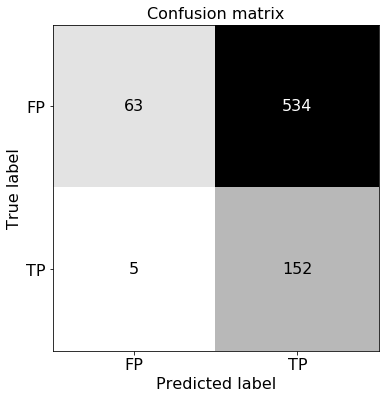

In [194]:
# feature1 = 'C_224_SHAP+C_083_SHAP+N_045_SHAP+N_143_SHAP'
# feature2 = 'sum'
feature1 = 'N_045'
feature2 = 'N_143'
# feature1 = 'sum'
# feature2 = 'var'
# feature2 = 'N_136_SHAP_rank'

X_train = tmp_valid_pos[[feature1, feature2]]
# X_train = tmp_valid_pos[['prob']]
y_train = tmp_valid_pos['condition_ori']

X_test = tmp_valid_next_pos[[feature1, feature2]]
# X_test = tmp_valid_next_pos[['prob']]
y_test = tmp_valid_next_pos['condition_ori']
#
X_train_sampled, y_train_sampled = undersampling(X_train, y_train, 
                                                 RandomUnderSampler(random_state=0), 30)


# clf = DecisionTreeClassifier(max_depth=3, class_weight={0: 1, 1: 8})
# clf = DecisionTreeClassifier(max_depth=3, class_weight={0: 1, 1:4}) #'N_138_SHAP_rank' 'C_083_SHAP_rank'
clf = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1:3})


clf = clf.fit(X_train_sampled, y_train_sampled)
# clf = clf.fit(X_train, y_train)

print('AUC-ROC=', roc_auc_score(y_test, clf.predict(X_test)) )
print('Accuracy=', accuracy_score(y_test, clf.predict(X_test)) )
print(confusion_matrix(y_test, clf.predict(X_test)))
confusion_matrix_plot(X_test, y_test, clf)
for thres in np.linspace(0, 1, 11):
    predict_mine = np.where(clf.predict_proba(X_test)[:, 1] > thres, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, predict_mine).ravel()
    print(tn, fp, fn, tp)

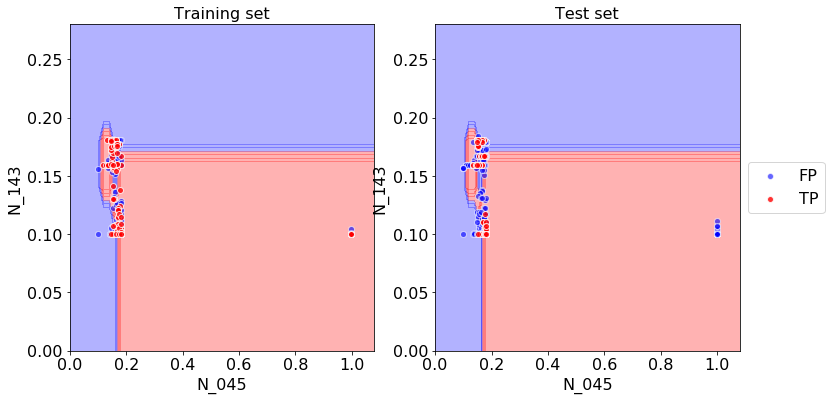

In [195]:
X_combined = np.vstack((X_train_sampled, X_test))
y_combined = np.hstack((y_train_sampled, y_test))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    fig, ax = plt.subplots(figsize=(12, 6))
    p1 = plt.subplot(121)
    p2 = plt.subplot(122)
   # setup marker generator and color map
    markers = ('o', 'o', 'o', '^', 'v')
    colors = ('blue', 'red', 'lightgreen', 'gray', 'cyan')
    alphas = (0.6, 0.8)
    labels = ('FP', 'TP')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
#     x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 3
#     x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 3
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    p1.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    p2.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_train, y_train = X[:test_idx[0], :], y[:test_idx[0]]
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y_train)):
        p1.scatter(x=X_train[y_train == cl, 0], y=X_train[y_train == cl, 1],
               alpha=alphas[idx], c=cmap(idx), edgecolor='white',
               marker=markers[idx], label=labels[idx])
    for idx, cl in enumerate(np.unique(y_test)):
        p2.scatter(x=X_test[y_test == cl, 0], y=X_test[y_test == cl, 1],
               alpha=alphas[idx], c=cmap(idx), edgecolor='white',
               marker=markers[idx], label=labels[idx])
    p1.set_title("Training set")
    p2.set_title("Test set")
    p1.set_xlabel(feature1)
    p1.set_ylabel(feature2)
    p2.set_xlabel(feature1)
    p2.set_ylabel(feature2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
plot_decision_regions(X_combined, y_combined,
         clf, test_idx=range(X_train_sampled.shape[0],X_combined.shape[0]))

# plt.legend(loc='lower right')
plt.show()
# plt.savefig('tree.png')

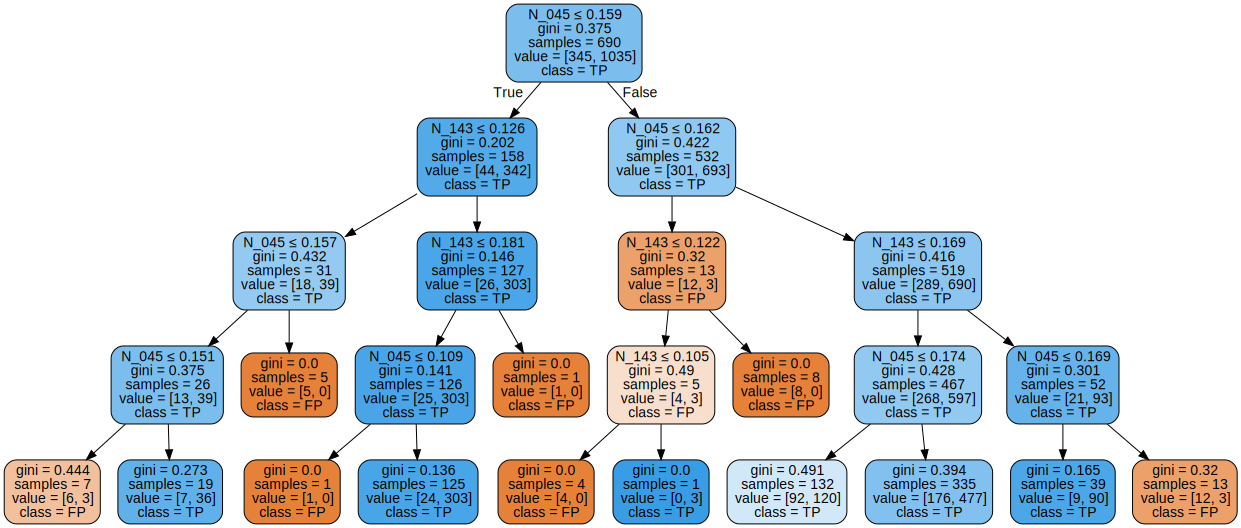

In [196]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(X_test),  
                         class_names=['FP', 'TP'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [197]:
params = {'max_depth':9, 'n_estimators':100,
          'objective': 'multi:softprob', 'num_class': 2,
          'early_stopping_rounds':10,
          'min_child_weight': 7,
          'subsample': 1.0,
          'colsample_bytree': 0.7
          }
xgb = xgboost.train(params, xgb_traintest, 100)
xgb_pred = xgb.predict(xgb_valid_next)

for T in np.linspace(0, 1, 11):
    predict_mine = np.where(xgb_pred[:, 1] > T, 1, 0)
    print(confusion_matrix(y_valid_next, predict_mine).ravel())

[     0 144754      0    188]
[142626   2128     12    176]
[143333   1421     16    172]
[143708   1046     22    166]
[143958    796     25    163]
[144142    612     29    159]
[144257    497     33    155]
[144373    381     41    147]
[144477    277     50    138]
[144605    149     77    111]
[144754      0    188      0]


In [198]:
clf_tp = DecisionTreeClassifier(max_depth=3, class_weight={0: 1, 1:2})
clf_tp.fit(X_train_sampled, y_train_sampled)
clf_tp_pred = clf_tp.predict_proba(X_test)
for T in np.linspace(0, 1, 11):
    predict_mine = np.where(clf_tp_pred[:, 1] > T, 1, 0)
    print(T, confusion_matrix(y_test, predict_mine).ravel())
    predict_mine2 = np.where(clf_tp_pred[:, 1] > T, 1, 0)
    print(T, confusion_matrix(y_test, predict_mine2).ravel())

0.0 [ 23 574   3 154]
0.0 [ 23 574   3 154]
0.1 [ 23 574   3 154]
0.1 [ 23 574   3 154]
0.2 [ 23 574   3 154]
0.2 [ 23 574   3 154]
0.30000000000000004 [ 23 574   3 154]
0.30000000000000004 [ 23 574   3 154]
0.4 [ 26 571   3 154]
0.4 [ 26 571   3 154]
0.5 [ 26 571   3 154]
0.5 [ 26 571   3 154]
0.6000000000000001 [435 162  95  62]
0.6000000000000001 [435 162  95  62]
0.7000000000000001 [454 143  96  61]
0.7000000000000001 [454 143  96  61]
0.8 [487 110 102  55]
0.8 [487 110 102  55]
0.9 [597   0 157   0]
0.9 [597   0 157   0]
1.0 [597   0 157   0]
1.0 [597   0 157   0]


In [207]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
    
    ratio={0: second_class}
#     ratio={0: int(major_class/r)}
    print(C)
    uds = sampler
    uds.set_params(ratio=ratio, random_state=0)
    X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

def plot_roc_curve(xgb_proba, y, df_valid, df_valid_next, color, mark, pos, text, label):
    pr_x = []
    pr_y = []
    
    roc_x = []
    roc_y = []
    tps = []
    fps = []
    min_score = min(xgb_proba)
    max_score = max(xgb_proba)
    t = np.linspace(0, 1, 11)
    thresholds = [round(x, 1) for x in t]
    FP=0
    TP=0
    P = sum(y)
    N = len(y) - P

    pr_x.append(1)
    pr_y.append(0)
    roc_x.append(1)
    roc_y.append(1)
    tps.append(0)
    fps.append(0)
    for (i, thres) in enumerate(thresholds):

        # The original model
        predict_thres = np.where(xgb_proba > thres, 1, 0)
        TN, FP, FN, TP = confusion_matrix(y, predict_thres).ravel()
        # TP/FP model
        if ((pos == True) & (thres==0.5)):#(thres!=0) & (thres!=1)):
            df_valid['condition'] = 'condition'
            df_valid['condition'].loc[((df_valid['fraud_label']==True) & (df_valid['predict_proba']>thres))] = 1 #'TP'
            df_valid['condition'].loc[((df_valid['fraud_label']==False) & (df_valid['predict_proba']>thres))] = 0# 'FP'
            df_valid['condition'].loc[((df_valid['fraud_label']==True) & (df_valid['predict_proba']<thres))] = 2 # 'FN'
            df_valid['condition'].loc[((df_valid['fraud_label']==False) & (df_valid['predict_proba']<thres))] = 3 #'TN'
            df_valid_next['condition'] = 'condition'
            df_valid_next['condition'].loc[((df_valid_next['fraud_label']==True) & (df_valid_next['predict_proba']>thres))] = 1 #'TP'
            df_valid_next['condition'].loc[((df_valid_next['fraud_label']==False) & (df_valid_next['predict_proba']>thres))] = 0 #'FP'
            df_valid_next['condition'].loc[((df_valid_next['fraud_label']==True) & (df_valid_next['predict_proba']<thres))] = 2 #'FN'
            df_valid_next['condition'].loc[((df_valid_next['fraud_label']==False) & (df_valid_next['predict_proba']<thres))] = 3 #'TN'
            tmp_pos = df_valid[df_valid['predict_proba'] > thres] 
            tmp_pos_next = df_valid_next[df_valid_next['predict_proba'] > thres] 

            feature1 = 'N_045'
            feature2 = 'N_143'
#             feature1 = 'N_138_SHAP_rank'
#             feature2 = 'C_083_SHAP_rank'
            X_train = tmp_pos[[feature1, feature2]]
            y_train = tmp_pos['condition']

            X_test = tmp_pos_next[[feature1, feature2]]
            y_test = tmp_pos_next['condition']

            X_train_sampled, y_train_sampled = undersampling(X_train, y_train, 
                                                     RandomUnderSampler(random_state=0), 30)
            clf_pos = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1:5})
            clf_pos.fit(X_train_sampled, y_train_sampled)
            clf_pos_pred = clf_pos.predict_proba(X_test)[:, 1]
        

            predict_pos_thres = np.where(clf_pos_pred > 0.6, 1, 0)
            TN_pos, FP_pos, FN_pos, TP_pos = confusion_matrix(y_test, predict_pos_thres).ravel()
           
        else:
            TN_pos = 0
            FP_pos = 0
            FN_pos = 0
            TP_pos = 0

        pr_x.append(safe_div( (TP-FN_pos), P))
        if (safe_div(TP, float(P)) == 0):
            pr_y.append(1) 
        else:
            pr_y.append(safe_div( (TP-FN_pos), ( (TP-FN_pos)+(FP-TN_pos) )))
        
        tps.append(TP-FN_pos)
        fps.append(FP-TN_pos)
        roc_x.append(safe_div((FP-TN_pos), N))
        roc_y.append(safe_div((TP-FN_pos), P))
#         print(thres, TP, FP, TN, FN)
        print(thres, TP, FP, FN_pos, TN_pos, (TP-FN_pos), (FP-TN_pos))
#         print('roc_fpr', (FP-TN_pos), N, 'roc_tpr', (TP-FN_pos), P, 'pr_rec', (TP-FN_pos)/P, 'pr_pre', (TP-FN_pos)/((TP-FN_pos)+(FP-TN_pos)) )

        FP=0
        TP=0
        
    if (np.min(pr_x) !=0):
        pr_x.append(0)
        pr_y.append(1)
        
    ax1.plot(pr_x, pr_y, c=color, label=label)
    ax2.plot(roc_x, roc_y, c=color, label=label)

#     ax1.scatter(pr_x, pr_y, c=color)
#     ax2.scatter(roc_x, roc_y, c=color)    
    
    for (i, thres) in enumerate(thresholds):   
        if (round(thres,1)==0.3) | (round(thres,1)==0.5) | (round(thres,1)==0.8): 

            ax1.scatter(pr_x[i+1], pr_y[i+1], c=color)
            ax2.scatter(roc_x[i+1], roc_y[i+1], c=color)   
            if ((text=='right')):
                ax1.text(pr_x[i+1]+0.02, pr_y[i+1], "{:.1f}".format(thres), fontsize=12, color=color)
                ax2.text(roc_x[i+1]+0.02, roc_y[i+1], "{:.1f}".format(thres), fontsize=12, color=color)
            else:
                ax1.text(pr_x[i+1]-0.1, pr_y[i+1], "{:.1f}".format(thres), fontsize=12, color=color)
                ax2.text(roc_x[i+1]-0.1, roc_y[i+1], "{:.1f}".format(thres), fontsize=12, color=color)
    return ax1, ax2, pr_x, pr_y, tps, fps

0.0 188 144754 0 0 188 144754
0.1 176 2423 0 0 176 2423
0.2 171 1526 0 0 171 1526
0.3 162 1141 0 0 162 1141
0.4 158 815 0 0 158 815
0.5 157 597 0 0 157 597
0.6 151 470 0 0 151 470
0.7 146 330 0 0 146 330
0.8 135 221 0 0 135 221
0.9 98 109 0 0 98 109
1.0 0 0 0 0 0 0
0.0 188 144754 0 0 188 144754
0.1 176 2423 0 0 176 2423
0.2 171 1526 0 0 171 1526
0.3 162 1141 0 0 162 1141
0.4 158 815 0 0 158 815
Counter({0: 2632, 1: 345})
X_resampled.shape: (690, 2), y_resampled: (690,)
y_resample:
1    345
0    345
dtype: int64
0.5 157 597 4 55 153 542
0.6 151 470 0 0 151 470
0.7 146 330 0 0 146 330
0.8 135 221 0 0 135 221
0.9 98 109 0 0 98 109
1.0 0 0 0 0 0 0


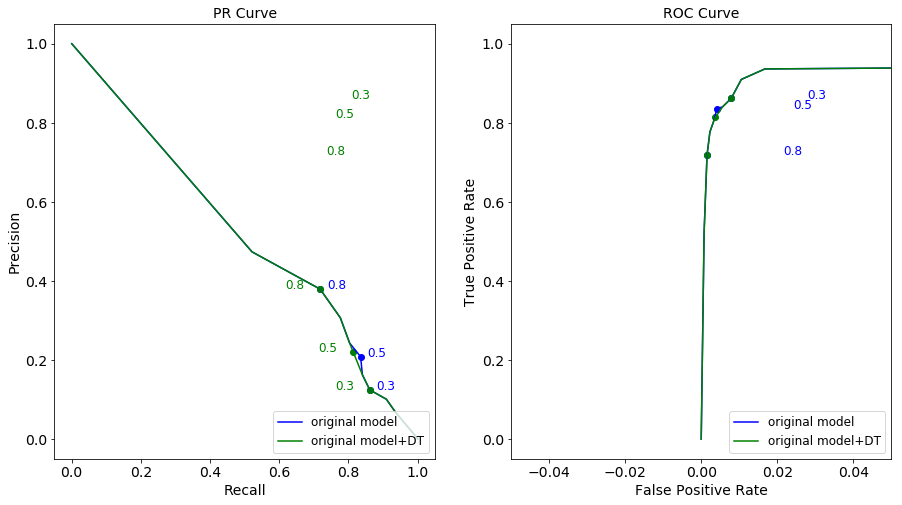

In [208]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 14})
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')
    
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,0.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
# score = clf.predict_proba(X_valid_selected)[:,1]
# plot_roc_curve(clf, clf.predict_proba(X_test)[:, 1], y_test.values.flatten(), 'b', 'x')
ax1_1, ax2_1, pr_x_1, pr_y_1, tps_1, fps_1 = plot_roc_curve(xgb_Mo1_pred_proba_valid_next, y_valid_next.values.flatten(), tmp_valid, tmp_valid_next, 'b', 'x', False, 'right', 'original model')
ax1_2, ax2_2, pr_x_2, pr_y_2, tps_2, fps_2 = plot_roc_curve(xgb_Mo1_pred_proba_valid_next, y_valid_next.values.flatten(), tmp_valid, tmp_valid_next, 'g', 'x', True, 'left', 'original model+DT')
# plot_roc_curve(xgb, xgb_pred[:, 1], y_valid_next.values.flatten(), 'r', 'x', True, clf_tp2_pred, y_test)

ax1.legend(loc=4, prop={'size': 12})
ax2.legend(loc=4, prop={'size': 12})

In [147]:
t = np.linspace(0, 1, 11)
thr = [round(x, 1) for x in t]

# np.round(pd.DataFrame([pr_x_1[:-1], pr_y_1[:-1]], columns = thr, index=['Recall', 'Precision'] ), 4)
df = np.round(pd.DataFrame([tps_1[:-1], fps_1[:-1]], columns = thr, index=['TPs', 'FPs'] ), 4)
df2 = np.round(pd.DataFrame([df.iloc[0,:]/df.iloc[0,5], df.iloc[1,:]/df.iloc[1,5]], columns = thr, index=['TPs', 'FPs']), 4)
df2

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
TPs,0.0,1.1534,1.0798,1.0552,1.0184,1.0,0.9755,0.9509,0.9018,0.8466,0.6810
FPs,0.0,181.8518,2.6734,1.7852,1.3141,1.0,0.7688,0.6244,0.4786,0.3480,0.1872


In [148]:
# np.round(pd.DataFrame([pr_x_1[:-1], pr_y_1[:-1]], columns = thr, index=['Recall', 'Precision'] ), 4)
df3 = np.round(pd.DataFrame([tps_2[:-1], fps_2[:-1]], columns = thr, index=['TPs', 'FPs'] ), 4)
df4 = np.round(pd.DataFrame([df3.iloc[0,:]/df.iloc[0,5], df3.iloc[1,:]/df.iloc[1,5]], columns = thr, index=['TPs', 'FPs']), 4)
df4

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
TPs,0.0,1.1534,1.0061,1.0368,1.0061,0.9387,0.9202,0.9325,0.8528,0.8282,0.6748
FPs,0.0,181.8518,2.2990,1.4711,1.0879,0.8191,0.6859,0.5415,0.4146,0.3342,0.1847


In [1569]:
# xgb_traintest_shap = xgboost.DMatrix(tmp_traintest_pos.iloc[:,0:-3], label=tmp_traintest_pos.iloc[:, -1])
# xgb_traintest_shap = xgboost.DMatrix(X_traintest_shap_sampled, y_traintest_shap_sampled)
# xgb_valid_shap = xgboost.DMatrix(tmp_valid_pos.iloc[:,0:-3], label=tmp_valid_pos.iloc[:, -1])

# xgb_traintest_shap = xgboost.DMatrix(X_train_shap_sampled.iloc[:, -16:], y_train_shap_sampled)
# xgb_valid_shap = xgboost.DMatrix(X_test.iloc[:, -16:], label=y_test)
# xgb_traintest_shap = xgboost.DMatrix(X_train_shap_sampled[['sum_pos']], y_train_shap_sampled)
# xgb_valid_shap = xgboost.DMatrix(X_test[['sum_pos']], label=y_test)
xgb_train_shap = xgboost.DMatrix(tmp_valid_pos[['C_224_SHAP+C_083_SHAP+N_046_SHAP', 'sum']], tmp_valid_pos.iloc[:, -2])
xgb_test_shap = xgboost.DMatrix(tmp_valid_next_pos[['C_224_SHAP+C_083_SHAP+N_046_SHAP', 'sum']], label=tmp_valid_next_pos.iloc[:, -2])

In [1576]:
params = {'max_depth':10, 'n_estimators':100,
          'objective': 'multi:softprob', 'num_class': 2,
          'early_stopping_rounds':10
#           'objective': 'binary:logistic'
}

xgb_shap = xgboost.train(params, xgb_train_shap, 100)
# confusion_matrix_plot(xgb_test_shap, y_test, xgb_shap)
# evaluate_scores(xgb_valid_shap, y_test, xgb_shap)

In [1155]:
tmp_valid[tmp_valid['C_083_SHAP']<0.1]['C_083'].value_counts()

0.102    503333
Name: C_083, dtype: int64

In [1705]:
tmp_valid[tmp_valid['C_224_SHAP']<1]['condition'].value_counts()

TN    591870
FP      2415
TP       242
FN        51
Name: condition, dtype: int64

In [1706]:
tmp_valid[tmp_valid['C_224_SHAP']>1]['condition'].value_counts()

TN    3431
FP     353
TP     111
FN       5
Name: condition, dtype: int64

In [1709]:
tmp_valid_pos[(tmp_valid_pos['C_224_SHAP']>1) & (tmp_valid_pos['C_083_SHAP']>0)]['C_224'].value_counts()

0.102    149
Name: C_224, dtype: int64

In [1730]:
tmp_valid[(tmp_valid['C_224_SHAP']>1) & (tmp_valid['C_083_SHAP']<0)]['C_224'].value_counts()

0.102    3373
Name: C_224, dtype: int64

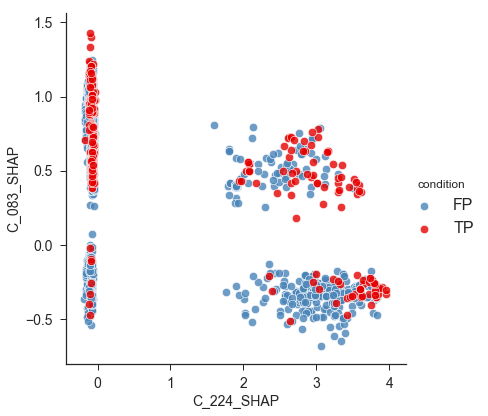

In [2470]:
kws = dict(s=70, linewidth=.7, edgecolor="w")

fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
fg.map(plt.scatter, 'C_224_SHAP', 'C_083_SHAP', alpha=0.8, **kws).add_legend()
# fg.set(xlim=(-1, 5), ylim=(1, 7), xlabel='SHAP value of the most important feature', ylabel='Sum of SHAP')
# fg.savefig("output1.png")

# fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
# fg.map(plt.scatter, 'C_224_SHAP+C_083_SHAP', 'sum', alpha=0.8, **kws).add_legend()
# fg.set(xlim=(-1, 5), ylim=(1, 7), xlabel='SHAP value of the most important 2 features', ylabel='Sum of SHAP')
# fg.savefig("output2.png")

# fg = seaborn.FacetGrid(data=tmp_valid_next_pos, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
# fg.map(plt.scatter, 'C_224_SHAP+C_083_SHAP+N_045_SHAP', 'sum', alpha=0.8, **kws).add_legend()
# fg.set(xlim=(-1, 5), ylim=(1, 7), xlabel='SHAP value of the most important 3 features', ylabel='Sum of SHAP')
# fg.savefig("output3.png")

# fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
# fg.map(plt.scatter, 'C_224_SHAP+C_083_SHAP+N_045_SHAP+N_143_SHAP', 'sum_abs', alpha=0.8, **kws).add_legend()
# fg.set(xlim=(-1, 5), ylim=(1, 7), xlabel='SHAP value of the most important 4 features', ylabel='Sum of SHAP')
# fg.savefig("output4.png")

In [56]:
fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
fg.map(plt.scatter, 'N_138', 'N_143', alpha=0.8, **kws).add_legend()

fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='cluster',  aspect=1, size=6, hue_order=[1, 2, 3, 4, 6, 7, 8, 5])

fg.map(plt.scatter, 'N_045', 'C_357', alpha=0.8, **kws).add_legend()
# fg.map(plt.scatter, 'C_028', 'N_045', alpha=0.8, **kws).add_legend()

NameError: name 'col_list_palette' is not defined

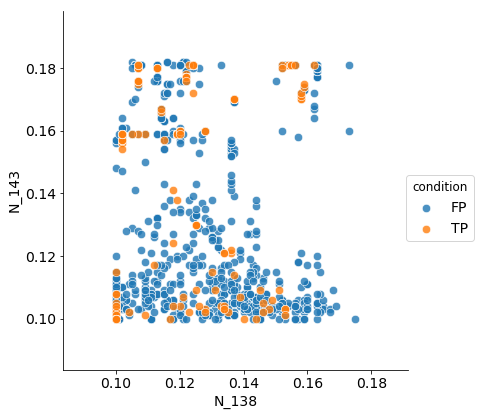

In [59]:
import seaborn
kws = dict(s=70, linewidth=.7, edgecolor="w")
fg = seaborn.FacetGrid(data=tmp_valid_pos, hue='condition', aspect=1, size=6, hue_order=['FP', 'TP'])
fg.map(plt.scatter, 'N_138', 'N_143', alpha=0.8, **kws).add_legend()

In [2113]:
sub1 = tmp_valid_pos[(tmp_valid_pos['C_224_SHAP']<1) & (tmp_valid_pos['C_083_SHAP']>0.1)].iloc[:, np.r_[22:44, -1]]
sub2 = tmp_valid_pos[(tmp_valid_pos['C_224_SHAP']>1) & (tmp_valid_pos['C_083_SHAP']>0.1)].iloc[:, np.r_[22:44, -1]]
sub3 = tmp_valid_pos[(tmp_valid_pos['C_224_SHAP']<1) & (tmp_valid_pos['C_083_SHAP']<0.1)].iloc[:, np.r_[22:44, -1]]
sub4 = tmp_valid_pos[(tmp_valid_pos['C_224_SHAP']>1) & (tmp_valid_pos['C_083_SHAP']<0.1)].iloc[:, np.r_[22:44, -1]]
sub1.to_csv("sub1_valid_pos.csv", sep='\t')
sub2.to_csv("sub2_valid_pos.csv", sep='\t')
sub3.to_csv("sub3_valid_pos.csv", sep='\t')
sub4.to_csv("sub4_valid_pos.csv", sep='\t')


# sub.iloc[:, 22:44].abs().mean().sort_values(ascending=False)
# fg = seaborn.FacetGrid(data=sub, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
# fg.map(plt.scatter, 'N_138_SHAP', 'N_046_SHAP', alpha=0.8, **kws).add_legend()
# sub_next = tmp_valid_next_pos[(tmp_valid_next_pos['C_224_SHAP']<1) & (tmp_valid_next_pos['C_083_SHAP']<0.1)]#.iloc[:, 22:44]
# fg = seaborn.FacetGrid(data=sub_next, hue='condition', palette=col_list_palette, aspect=1, size=6, hue_order=['FP', 'TP'])
# fg.map(plt.scatter, 'N_138_SHAP', 'N_143_SHAP', alpha=0.8, **kws).add_legend()

In [2108]:
sub[sub['condition']=='TP'].iloc[:, 22:44].mean(axis=0).sort_values(ascending=False)

N_138_SHAP    0.529319
N_046_SHAP    0.501266
N_045_SHAP    0.337823
N_143_SHAP    0.301305
N_153_SHAP    0.267432
N_063_SHAP    0.255516
C_142_SHAP    0.234959
N_148_SHAP    0.215474
N_152_SHAP    0.214999
N_136_SHAP    0.185393
C_326_SHAP    0.125367
N_141_SHAP    0.104981
N_130_SHAP    0.046724
C_210_SHAP    0.020537
C_028_SHAP    0.016983
C_287_SHAP    0.004687
C_268_SHAP   -0.002976
C_096_SHAP   -0.018304
C_048_SHAP   -0.029382
C_224_SHAP   -0.100177
C_357_SHAP   -0.222583
C_083_SHAP   -0.237632
dtype: float32

In [ ]:
tmp_valid[(tmp_valid['C_224_SHAP']>1) & (tmp_valid['C_083_SHAP']<0)]['C_083'].value_counts()

(array([ 2.,  1.,  4.,  8., 21., 20., 23., 35., 23., 44., 41., 31., 23.,
        20., 17., 15., 11., 12.,  1.,  1.]),
 array([-0.13077807,  0.11417044,  0.35911896,  0.60406748,  0.849016  ,
         1.09396452,  1.33891304,  1.58386155,  1.82881007,  2.07375859,
         2.31870711,  2.56365563,  2.80860415,  3.05355266,  3.29850118,
         3.5434497 ,  3.78839822,  4.03334674,  4.27829525,  4.52324377,
         4.76819229]),
 <a list of 20 Patch objects>)

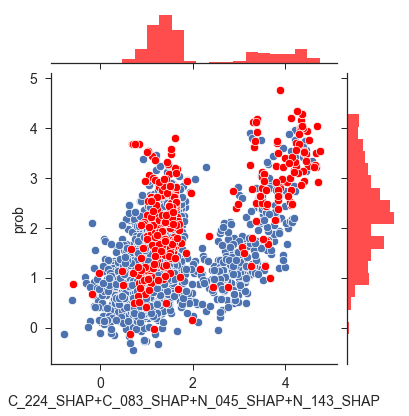

In [2071]:
feature1 = 'C_224_SHAP+C_083_SHAP+N_045_SHAP+N_143_SHAP'
p = sns.JointGrid(
    x = tmp_valid_pos[tmp_valid_pos['condition']=='FP'][feature1],
    y = tmp_valid_pos[tmp_valid_pos['condition']=='FP']['prob']
    )

p = p.plot_joint(
    plt.scatter, **kws, 
    )

p.x = tmp_valid_pos[tmp_valid_pos['condition']=='TP'][feature1]
p.y = tmp_valid_pos[tmp_valid_pos['condition']=='TP']['prob']
p.plot_joint(plt.scatter, marker='o', c='r', **kws)

# p.ax_marg_x.hist(
#     tmp_valid_pos[tmp_valid_pos['condition']=='FP'][feature1],
#     bins=20,
#     alpha = 0.7
#     )

# p.ax_marg_y.hist(
#     tmp_valid_pos[tmp_valid_pos['condition']=='FP']['prob'],
#     orientation = 'horizontal',
#     bins=20,
#     alpha = 0.7
#     )

p.ax_marg_x.hist(
    tmp_valid_pos[tmp_valid_pos['condition']=='TP'][feature1],
    alpha = 0.7,
    color="r",
    bins=20,
    range = (np.min(tmp_valid_pos[tmp_valid_pos['condition']=='TP'][feature1]), np.max(tmp_valid_pos[tmp_valid_pos['condition']=='TP'][feature1]))
    )

p.ax_marg_y.hist(
    tmp_valid_pos[tmp_valid_pos['condition']=='TP']['prob'],
    orientation = 'horizontal',
    alpha = 0.7,
    color="r", 
    bins=20,
    range = (np.min(tmp_valid_pos[tmp_valid_pos['condition']=='TP']['prob']), np.max(tmp_valid_pos[tmp_valid_pos['condition']=='TP']['prob'])),
    )

# fg.savefig("output1.png")

In [40]:
tmp_valid_next_pos['condition'].value_counts()

FP    612
TP    159
Name: condition, dtype: int64

In [106]:
tmp_valid_pos[tmp_valid_pos['condition']=='TP']

,C_028,C_048,C_083,C_096,C_142,C_210,C_224,C_268,C_287,C_326,...,prob,sum,sum_abs,var,fraud_label,predict_ori,predict_proba,condition_ori,condition,cluster
0,0.100,0.100,0.100,0.102,0.102,0.102,0.100,0.102,0.102,0.100,...,3.762517,8.084645,8.441952,0.103114,1,1,0.977302,1,TP,10
1,0.100,0.100,0.100,0.100,0.102,0.101,0.100,0.100,0.100,0.100,...,1.966414,6.288542,7.184396,0.113479,1,1,0.877225,1,TP,10
53,0.100,0.102,0.100,0.100,0.102,0.102,0.100,0.100,0.102,0.102,...,1.731833,6.053961,7.886788,0.179178,1,1,0.849647,1,TP,10
55,0.124,0.100,0.102,0.100,0.100,0.101,0.102,0.100,0.100,0.102,...,4.165468,8.487596,10.269555,1.425098,1,1,0.984715,1,TP,4
57,0.100,0.102,0.100,0.102,0.102,0.102,0.100,0.102,0.102,0.100,...,2.212645,6.534772,6.807583,0.085317,1,1,0.901379,1,TP,10
58,0.100,0.102,0.100,0.102,0.102,0.102,0.100,0.102,0.102,0.100,...,3.338243,7.660371,7.913004,0.112691,1,1,0.965718,1,TP,10
60,0.100,0.100,0.100,0.100,0.100,0.101,0.100,0.100,0.100,0.102,...,1.792887,6.115015,7.090312,0.278632,1,1,0.857281,1,TP,9
61,0.102,0.100,0.100,0.100,0.102,0.101,0.100,0.100,0.100,0.102,...,3.202772,7.524899,8.366883,0.260035,1,1,0.960939,1,TP,9
62,0.124,0.100,0.100,0.100,0.100,0.101,0.102,0.100,0.100,0.102,...,5.007994,9.330122,10.084798,1.097313,1,1,0.993360,1,TP,4
63,0.186,0.100,0.102,0.100,0.100,0.101,0.102,0.100,0.100,0.102,...,4.239521,8.561648,10.638169,1.530972,1,1,0.985790,1,TP,4


### First clustering

In [258]:
tmp_valid_pos[tmp_valid_pos['cluster']==3].iloc[:, 22:44].abs().mean(axis=0).sort_values(ascending=False)

N_143_SHAP    0.944573
N_045_SHAP    0.864077
N_138_SHAP    0.689115
N_046_SHAP    0.568917
C_083_SHAP    0.521801
C_357_SHAP    0.510515
C_326_SHAP    0.505985
N_153_SHAP    0.415654
N_063_SHAP    0.348342
N_152_SHAP    0.337076
C_142_SHAP    0.336860
N_130_SHAP    0.224907
N_148_SHAP    0.195861
N_141_SHAP    0.169783
N_136_SHAP    0.160496
C_224_SHAP    0.140505
C_048_SHAP    0.124949
C_287_SHAP    0.101109
C_210_SHAP    0.091338
C_028_SHAP    0.077156
C_096_SHAP    0.046469
C_268_SHAP    0.019472
dtype: float32

In [287]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

# generate the linkage matrix
X = tmp_valid_pos.iloc[:, 22:44] #tmp_valid_pos.iloc[:, np.r_[22:44, -3] ]
# X = tmp_valid_pos[tmp_valid_pos['cluster']==8].iloc[:, 22:44]
Z = linkage(X, method='average')
c, coph_dists = cophenet(Z, pdist(X, 'euclidean'))

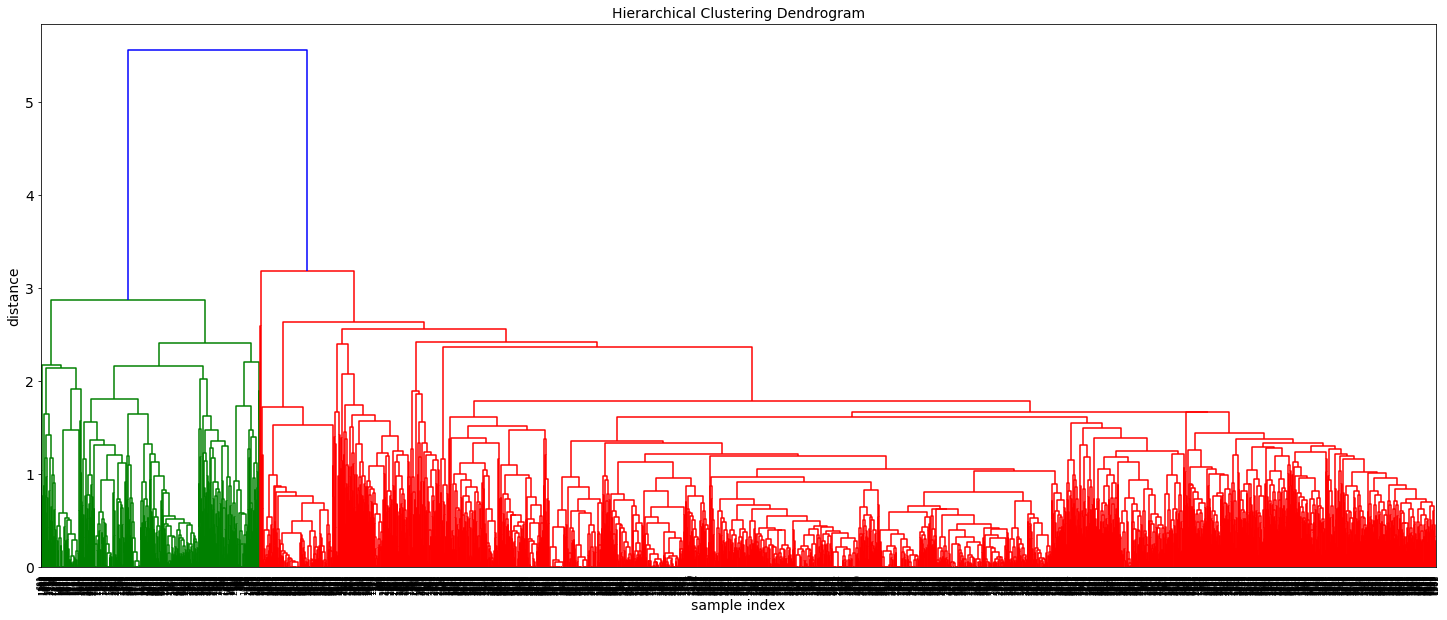

In [288]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [279]:
tmp_valid_pos['C_224_SHAP'].max()

6.011334

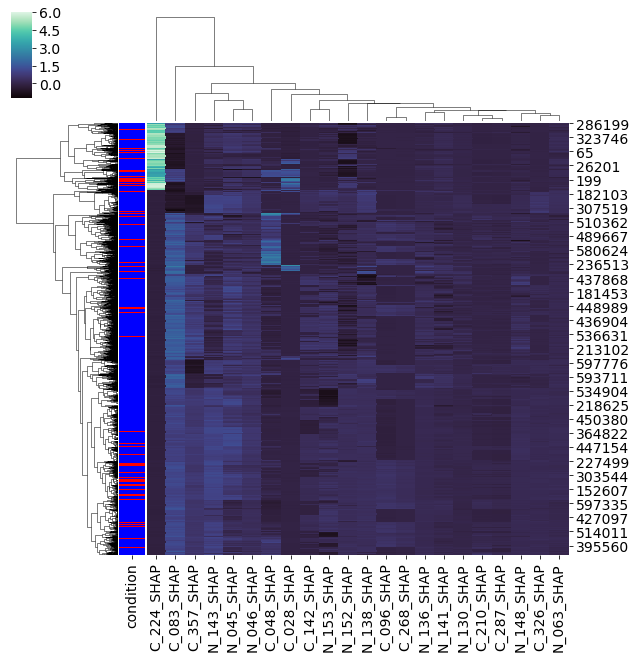

In [289]:
lut = dict(zip(tmp_valid_pos['condition'].unique(), "rbg"))
row_colors = tmp_valid_pos['condition'].map(lut)
g = sns.clustermap(tmp_valid_pos.iloc[:, 22:44], method="complete", metric="euclidean", cmap="mako", row_colors=row_colors)

In [276]:
from scipy.cluster.hierarchy import fcluster
max_d = 4
clusters = fcluster(Z, max_d, criterion='distance')

# test = tmp_valid_pos[tmp_valid_pos['cluster']==8].copy()
# test['cluster2'] = clusters
tmp_valid_pos['cluster'] = clusters
Counter(clusters)

Counter({1: 319, 2: 148, 3: 158, 4: 355, 5: 41, 6: 1956})

In [277]:
(pd.crosstab(tmp_valid_pos["cluster"], tmp_valid_pos['condition']))
# pd.crosstab(test['cluster2'], test['condition'])

condition,FP,TP
cluster,,
1,278,41
2,78,70
3,154,4
4,308,47
5,31,10
6,1783,173


In [231]:
tmp_valid_pos[tmp_valid_pos['cluster']==1].to_csv('cluster1.csv', sep=',')
tmp_valid_pos[tmp_valid_pos['cluster']==2].to_csv('cluster2.csv', sep=',')
tmp_valid_pos[tmp_valid_pos['cluster']==3].to_csv('cluster3.csv', sep=',')
tmp_valid_pos[tmp_valid_pos['cluster']==4].to_csv('cluster4.csv', sep=',')
tmp_valid_pos[tmp_valid_pos['cluster']==5].to_csv('cluster5.csv', sep=',')
tmp_valid_pos[tmp_valid_pos['cluster']==6].to_csv('cluster6.csv', sep=',')
tmp_valid_pos.to_csv('tmp_valid_pos.csv', sep=',')

In [230]:
cluster3 = tmp_valid_pos[tmp_valid_pos['cluster']==3].iloc[:, 0:22]
frequent_itemsets = apriori(cluster3, min_support=0.6, use_colnames=True)
frequent_itemsets
# cluster3.shape

,support,itemsets


In [215]:
explainer = shap.TreeExplainer(xgb)
# shap_xgb_test = explainer.shap_values(xgb_valid)
shap.force_plot(np.array(tmp_valid_pos[tmp_valid_pos['cluster']==3].iloc[:, 22:45]), tmp_valid_pos[tmp_valid_pos['cluster']==3].iloc[:, 0:22])

In [280]:
shap.force_plot(np.array(tmp_valid_pos[tmp_valid_pos['cluster']==1].iloc[:, 22:45]), tmp_valid_pos[tmp_valid_pos['cluster']==1].iloc[:, 0:22])

In [281]:
# tmp_valid_pos[(tmp_valid_pos['N_046']==0.173) & (tmp_valid_pos['N_063']==0.173)]['condition'].value_counts()
# tmp_valid_pos[(tmp_valid_pos['N_046']==0.172) & (tmp_valid_pos['N_063']==0.172) & (tmp_valid_pos['N_045']==0.181)]['condition'].value_counts()
# tmp_valid_pos[(tmp_valid_pos['C_028']==0.1) &(tmp_valid_pos['C_224']==0.1) & (tmp_valid_pos['C_357']==0.1) & (tmp_valid_pos['N_136']==0.1) & (tmp_valid_pos['N_138']==0.1)]['condition'].value_counts()
tmp_valid_next_pos[(tmp_valid_next_pos['C_028']==0.1) &(tmp_valid_next_pos['C_224']==0.1) & (tmp_valid_next_pos['C_357']==0.1) & (tmp_valid_next_pos['N_136']==0.1) & (tmp_valid_next_pos['N_138']==0.1)]['condition'].value_counts()

FP    48
TP     2
Name: condition, dtype: int64

In [285]:
tmp_valid_pos[(tmp_valid_pos['C_083']==0.1) &(tmp_valid_pos['C_357']==0.102) & (tmp_valid_pos['N_046']==0.173)]['condition'].value_counts()
tmp_valid_next_pos[(tmp_valid_next_pos['C_083']==0.1) &(tmp_valid_next_pos['C_357']==0.102) & (tmp_valid_next_pos['N_046']==0.173)]['condition'].value_counts()
# tmp_valid_next_pos[(tmp_valid_next_pos['C_028']==0.1) &(tmp_valid_next_pos['C_224']==0.1) & (tmp_valid_next_pos['C_357']==0.1) & (tmp_valid_next_pos['N_136']==0.1) & (tmp_valid_next_pos['N_138']==0.1)]['condition'].value_counts()

FP    35
TP     6
Name: condition, dtype: int64

In [ ]:
C_028=0.1,                  
      C_224=0.1,                  
      C_357=0.1,                  
      N_136=0.1,                  
      N_138=0.1

In [216]:
for i in np.arange(1, 9):
    clu = i
    test = tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, 22:44]
    t = np.argsort(test.abs().mean(axis=0))[::-1]
    test.mean(axis=0).sort_values(ascending=False)
    print("Cluster=", clu)
#     print(tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, t[0:5]].describe())
    display(tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, t[0:20]].describe())

Cluster= 1


,C_224,C_083,N_152,N_045,N_046,N_143,C_028,N_141,N_063,N_138,C_048,N_153,N_148,N_136,N_130,C_357,C_142,C_210,C_287,C_326
count,3.190000e+02,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,3.190000e+02,319.000000,319.000000,319.000000,3.190000e+02
mean,1.020000e-01,0.101555,0.121000,0.156887,0.147944,0.169718,0.101812,0.124850,0.147944,0.124423,0.102508,0.502812,0.163931,0.124624,0.157044,1.000000e-01,0.100313,0.101144,0.100295,1.020000e-01
std,2.223935e-16,0.000833,0.015061,0.011753,0.011567,0.010870,0.007922,0.008762,0.011567,0.010730,0.008764,0.396336,0.006754,0.008333,0.004478,5.698832e-16,0.000728,0.000352,0.000710,2.223935e-16
min,1.020000e-01,0.100000,0.100000,0.134000,0.127000,0.107000,0.100000,0.102000,0.127000,0.102000,0.100000,0.174000,0.109000,0.102000,0.109000,1.000000e-01,0.100000,0.101000,0.100000,1.020000e-01
25%,1.020000e-01,0.102000,0.104000,0.148000,0.139000,0.159000,0.100000,0.120000,0.139000,0.119000,0.100000,0.186000,0.163000,0.120000,0.158000,1.000000e-01,0.100000,0.101000,0.100000,1.020000e-01
50%,1.020000e-01,0.102000,0.131000,0.157000,0.148000,0.176000,0.100000,0.124000,0.148000,0.122000,0.100000,0.195000,0.166000,0.124000,0.158000,1.000000e-01,0.100000,0.101000,0.100000,1.020000e-01
75%,1.020000e-01,0.102000,0.133000,0.167000,0.158000,0.177000,0.100000,0.126000,0.158000,0.124000,0.102000,0.999000,0.166000,0.126000,0.158000,1.000000e-01,0.100000,0.101000,0.100000,1.020000e-01
max,1.020000e-01,0.102000,0.143000,0.182000,0.173000,0.182000,0.168000,0.175000,0.173000,0.173000,0.150000,0.999000,0.176000,0.173000,0.158000,1.000000e-01,0.102000,0.102000,0.102000,1.020000e-01


Cluster= 2


,C_224,C_028,C_083,C_048,N_152,N_045,N_046,N_141,N_063,N_143,N_148,N_136,N_153,N_138,N_130,C_357,C_210,C_287,C_142,C_326
count,1.480000e+02,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,1.480000e+02,148.000000,148.000000,148.000000,148.000000
mean,1.020000e-01,0.129568,0.100824,0.120135,0.115703,0.152257,0.143824,0.122088,0.143824,0.170230,0.163318,0.122047,0.607986,0.122101,0.157446,1.000000e-01,0.101216,0.100432,0.100446,0.101973
std,2.227986e-16,0.029405,0.000988,0.023743,0.015127,0.016599,0.015234,0.006517,0.015234,0.011099,0.009683,0.006401,0.408602,0.009946,0.004829,2.506484e-16,0.000413,0.000826,0.000835,0.000232
min,1.020000e-01,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.174000,0.100000,0.100000,1.000000e-01,0.101000,0.100000,0.100000,0.100000
25%,1.020000e-01,0.102000,0.100000,0.100000,0.100000,0.147000,0.138000,0.120000,0.138000,0.159000,0.163000,0.120000,0.184000,0.119000,0.158000,1.000000e-01,0.101000,0.100000,0.100000,0.102000
50%,1.020000e-01,0.124000,0.100000,0.101000,0.111000,0.157000,0.148000,0.124000,0.148000,0.177000,0.166000,0.124000,0.999000,0.122000,0.158000,1.000000e-01,0.101000,0.100000,0.100000,0.102000
75%,1.020000e-01,0.146000,0.102000,0.148000,0.133000,0.166000,0.157000,0.124000,0.157000,0.177000,0.166000,0.124000,0.999000,0.122000,0.158000,1.000000e-01,0.101000,0.100000,0.100000,0.102000
max,1.020000e-01,0.190000,0.102000,0.160000,0.142000,0.180000,0.171000,0.143000,0.171000,0.181000,0.176000,0.141000,0.999000,0.159000,0.158000,1.000000e-01,0.102000,0.102000,0.102000,0.102000


Cluster= 3


,N_143,N_045,N_138,N_046,C_083,C_357,C_326,N_153,N_063,N_152,C_142,N_130,N_148,N_141,N_136,C_224,C_048,C_287,C_210,C_028
count,158.000000,158.000000,158.000000,158.000000,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,1.580000e+02,158.000000,158.000000,158.000000,158.000000
mean,0.103728,0.221956,0.101247,0.171633,1.020000e-01,1.000000e-01,0.100139,0.214551,0.171633,0.119361,0.101861,0.103108,0.106019,0.112139,0.100962,1.000000e-01,0.103848,0.100899,0.101551,0.101165
std,0.015557,0.180062,0.006619,0.003856,2.366725e-16,2.645164e-16,0.000511,0.126907,0.003856,0.123027,0.000511,0.012725,0.015262,0.027134,0.004429,2.645164e-16,0.012569,0.000998,0.000794,0.008029
min,0.100000,0.154000,0.100000,0.145000,1.020000e-01,1.000000e-01,0.100000,0.174000,0.145000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.100000,0.101000,0.100000
25%,0.100000,0.181000,0.100000,0.172000,1.020000e-01,1.000000e-01,0.100000,0.194000,0.172000,0.100000,0.102000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.100000,0.101000,0.100000
50%,0.100000,0.182000,0.100000,0.173000,1.020000e-01,1.000000e-01,0.100000,0.196000,0.173000,0.100000,0.102000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.100000,0.101000,0.100000
75%,0.100000,0.182000,0.100000,0.173000,1.020000e-01,1.000000e-01,0.100000,0.197000,0.173000,0.101000,0.102000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.102000,0.102000,0.100000
max,0.181000,0.999000,0.163000,0.174000,1.020000e-01,1.000000e-01,0.102000,0.999000,0.174000,0.999000,0.102000,0.158000,0.170000,0.179000,0.129000,1.000000e-01,0.158000,0.102000,0.106000,0.184000


Cluster= 4


,C_083,C_048,C_357,C_096,N_143,N_045,N_138,N_046,N_136,C_268,N_152,N_153,N_148,N_141,C_210,N_063,C_224,C_028,C_142,C_287
count,3.550000e+02,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,3.550000e+02,355.000000,355.000000,355.000000
mean,1.000000e-01,0.139499,0.101820,0.101200,0.108445,0.184352,0.111172,0.156924,0.107823,0.101200,0.117727,0.570392,0.108685,0.121907,0.101817,0.156924,1.000000e-01,0.102124,0.100389,0.101476
std,6.531766e-16,0.018094,0.000574,0.000981,0.015375,0.124442,0.016523,0.012164,0.013981,0.000981,0.067698,0.406857,0.014532,0.024618,0.000387,0.012164,6.531766e-16,0.011230,0.000793,0.000881
min,1.000000e-01,0.102000,0.100000,0.100000,0.100000,0.125000,0.100000,0.118000,0.100000,0.100000,0.100000,0.173000,0.100000,0.100000,0.101000,0.118000,1.000000e-01,0.100000,0.100000,0.100000
25%,1.000000e-01,0.124000,0.102000,0.100000,0.100000,0.156000,0.100000,0.147000,0.100000,0.100000,0.100000,0.185000,0.100000,0.100000,0.102000,0.147000,1.000000e-01,0.100000,0.100000,0.100000
50%,1.000000e-01,0.148000,0.102000,0.102000,0.102000,0.168000,0.100000,0.159000,0.100000,0.102000,0.110000,0.197000,0.103000,0.111000,0.102000,0.159000,1.000000e-01,0.100000,0.100000,0.102000
75%,1.000000e-01,0.150000,0.102000,0.102000,0.108000,0.177000,0.120500,0.168000,0.110000,0.102000,0.121000,0.999000,0.111000,0.138000,0.102000,0.168000,1.000000e-01,0.100000,0.100000,0.102000
max,1.000000e-01,0.160000,0.102000,0.102000,0.181000,0.999000,0.176000,0.174000,0.162000,0.102000,0.999000,0.999000,0.171000,0.179000,0.102000,0.174000,1.000000e-01,0.188000,0.102000,0.102000


Cluster= 5


,C_028,C_083,N_136,N_141,N_046,N_138,N_045,N_143,N_152,C_224,N_130,N_063,N_153,C_048,N_148,C_357,C_142,C_287,C_326,C_096
count,41.000000,4.100000e+01,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,4.100000e+01,41.000000,41.000000,41.000000,41.000000,41.000000,4.100000e+01,41.000000,41.000000,4.100000e+01,41.000000
mean,0.130244,1.000000e-01,0.113293,0.113390,0.147317,0.115976,0.156317,0.168707,0.123317,1.000000e-01,0.157805,0.147317,0.604341,0.100634,0.157268,1.000000e-01,0.100195,0.100098,1.020000e-01,0.100049
std,0.028172,2.810038e-17,0.006979,0.006822,0.009763,0.015124,0.009763,0.008670,0.015620,2.810038e-17,0.000749,0.009763,0.409440,0.003048,0.006376,2.810038e-17,0.000601,0.000436,2.810038e-17,0.000312
min,0.102000,1.000000e-01,0.102000,0.103000,0.137000,0.102000,0.146000,0.154000,0.100000,1.000000e-01,0.154000,0.137000,0.178000,0.100000,0.145000,1.000000e-01,0.100000,0.100000,1.020000e-01,0.100000
25%,0.108000,1.000000e-01,0.109000,0.109000,0.138000,0.109000,0.147000,0.161000,0.111000,1.000000e-01,0.158000,0.138000,0.191000,0.100000,0.154000,1.000000e-01,0.100000,0.100000,1.020000e-01,0.100000
50%,0.124000,1.000000e-01,0.114000,0.114000,0.145000,0.114000,0.154000,0.166000,0.129000,1.000000e-01,0.158000,0.145000,0.999000,0.100000,0.158000,1.000000e-01,0.100000,0.100000,1.020000e-01,0.100000
75%,0.146000,1.000000e-01,0.114000,0.114000,0.152000,0.114000,0.161000,0.180000,0.142000,1.000000e-01,0.158000,0.152000,0.999000,0.100000,0.159000,1.000000e-01,0.100000,0.100000,1.020000e-01,0.100000
max,0.192000,1.000000e-01,0.129000,0.129000,0.169000,0.163000,0.178000,0.181000,0.142000,1.000000e-01,0.158000,0.169000,0.999000,0.118000,0.170000,1.000000e-01,0.102000,0.102000,1.020000e-01,0.102000


Cluster= 6


,C_083,N_143,C_357,N_045,N_046,N_138,N_153,N_152,C_142,N_148,N_136,C_096,N_063,C_048,N_141,C_326,C_268,C_224,N_130,C_210
count,1.956000e+03,1956.000000,1956.00000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1.956000e+03,1956.000000,1956.000000
mean,1.000000e-01,0.106585,0.10176,0.195193,0.165739,0.106164,0.298435,0.116892,0.101287,0.106429,0.103847,0.100741,0.165742,0.104293,0.112164,0.100578,0.100741,1.000000e-01,0.105323,0.101460
std,3.498097e-15,0.018151,0.00065,0.129110,0.007804,0.015538,0.273208,0.098913,0.000958,0.015006,0.011212,0.000966,0.007805,0.011027,0.022473,0.000907,0.000966,3.498097e-15,0.014837,0.000614
min,1.000000e-01,0.100000,0.10000,0.135000,0.127000,0.100000,0.173000,0.100000,0.100000,0.100000,0.100000,0.100000,0.127000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.101000
25%,1.000000e-01,0.100000,0.10200,0.171000,0.162000,0.100000,0.190000,0.100000,0.100000,0.100000,0.100000,0.100000,0.162000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.101000
50%,1.000000e-01,0.100000,0.10200,0.177000,0.168000,0.100000,0.195000,0.100000,0.102000,0.100000,0.100000,0.100000,0.168000,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,0.101000
75%,1.000000e-01,0.102000,0.10200,0.181000,0.172000,0.100000,0.198000,0.110000,0.102000,0.105000,0.100000,0.102000,0.172000,0.102000,0.112000,0.102000,0.102000,1.000000e-01,0.101000,0.102000
max,1.000000e-01,0.183000,0.10200,0.999000,0.174000,0.175000,0.999000,0.999000,0.102000,0.174000,0.168000,0.102000,0.174000,0.160000,0.179000,0.102000,0.102000,1.000000e-01,0.160000,0.106000


Cluster= 7


,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cluster= 8


,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# display(pd.crosstab(tmp_valid_pos["C_224_SHAP_rank"], tmp_valid_pos['condition']))
# display(pd.crosstab(tmp_valid_pos["C_083_SHAP_rank"], tmp_valid_pos['condition']))
# display(pd.crosstab(tmp_valid_pos["N_138_SHAP_rank"], tmp_valid_pos['condition']))
display(pd.crosstab(tmp_valid_pos["N_136_SHAP_rank"], tmp_valid_pos['condition']))

condition,FP,TP
N_136_SHAP_rank,,
2,13,0
3,58,1
4,67,18
5,70,13
6,68,17
7,102,12
8,105,13
9,171,29
10,306,32


In [3744]:
# accociation rule
# tmp_valid_pos[(tmp_valid_pos['C_083_SHAP_rank']==1) ]['condition'].value_counts()
# tmp_valid_pos[(tmp_valid_pos['N_153_SHAP_rank']<=5) ]['condition'].value_counts()

FP    1423
TP     118
Name: condition, dtype: int64

In [91]:
tmp_valid_next_pos[tmp_valid_next_pos['N_136_SHAP_rank']>20]['condition'].value_counts()

TP    2
Name: condition, dtype: int64

In [3163]:
tmp_valid_pos.to_csv("tmp_valid_pos.csv", sep='\t')

In [2526]:
tmp_valid_next_pos['condition'].value_counts()

FP    612
TP    159
Name: condition, dtype: int64

In [2873]:
tmp_valid_next_pos[(tmp_valid_next_pos['N_045_SHAP_rank']==1) & (tmp_valid_next_pos['N_138_SHAP_rank']==2)]['condition'].value_counts()

FP    10
TP     1
Name: condition, dtype: int64

In [3117]:
tmp_valid_next_pos[(tmp_valid_next_pos['N_138_SHAP_rank']==1)]['condition'].value_counts()


FP    23
TP     1
Name: condition, dtype: int64

In [2903]:
tmp_valid_next_pos[(tmp_valid_next_pos['C_142_SHAP_rank']<=6) & (tmp_valid_next_pos['N_143_SHAP_rank']>6) & (tmp_valid_next_pos['C_287_SHAP_rank']>15)]['condition'].value_counts()

FP    45
TP     6
Name: condition, dtype: int64

In [2895]:
tmp_valid_next_pos[(tmp_valid_next_pos['C_083_SHAP_rank']==1) & (tmp_valid_next_pos['N_138_SHAP_rank']>9) ]['condition'].value_counts()

FP    62
TP     6
Name: condition, dtype: int64

In [2770]:
rule1 = tmp_valid_next_pos[ (tmp_valid_next_pos['N_045_SHAP_rank']==1) & (tmp_valid_next_pos['N_138_SHAP_rank']==2) & (tmp_valid_next_pos['N_143_SHAP_rank']==3)]['condition'].index#value_counts()

In [2771]:
tmp_valid_next_pos.ix[rule1]['condition'].value_counts()

FP    10
TP     1
Name: condition, dtype: int64

In [2772]:
rule2 = tmp_valid_next_pos[(tmp_valid_next_pos['C_096_SHAP_rank']==13) & (tmp_valid_next_pos['C_048_SHAP_rank']>14) & (tmp_valid_next_pos['N_141_SHAP_rank']>13)]['condition'].index#value_counts()

In [2973]:
for i in np.arange(45, 67):
    print(pd.crosstab(tmp_valid_pos.iloc[:, i], tmp_valid_pos['condition']))

condition          FP   TP
C_083_SHAP_rank           
1                1423  118
2                 555  109
3                 257   45
4                 162   47
5                  77   15
6                  44   14
7                  42    1
8                  38    1
9                  21    0
10                 41    0
11                 36    0
12                 23    2
13                 13    0
14                 10    0
15                 17    0
16                  1    0
17                  3    0
18                  3    1
20                  2    0
condition         FP   TP
C_224_SHAP_rank          
1                353  111
5                  3    0
6                 13    0
7                 16    2
8                 53    3
9                 62    1
10                92    6
11               147   13
12               249   18
13               432   26
14               446   24
15               367   44
16               268   51
17               157   31
18               

condition         FP  TP
C_142_SHAP_rank         
2                  0   1
3                 24   0
4                 43   1
5                 96   4
6                149   9
7                143   9
8                255  15
9                213  23
10               123  17
11               114  14
12               125  13
13               156  19
14               178  19
15               172  30
16               154  28
17               195  29
18               169  29
19               143  24
20               139  27
21               117  27
22                60  15
condition         FP  TP
N_063_SHAP_rank         
3                  6   1
4                 14   0
5                 78   1
6                101   2
7                118  17
8                125  21
9                229  41
10               216  31
11               237  40
12               227  19
13               232  31
14               216  41
15               193  20
16               176  15
17               142  18


In [2739]:
# rule = rule1.append(rule2).unique()
tmp_valid_next_pos.ix[rule2]['condition'].value_counts()

TP    6
FP    5
Name: condition, dtype: int64

In [2994]:
# tmp_valid_pos[(tmp_valid_pos['N_143_SHAP_rank']==3) ]['condition'].value_counts()
# tmp_valid_pos[(tmp_valid_pos['N_138_SHAP_rank']==1) ]['condition'].value_counts()
tmp_valid_pos[(tmp_valid_pos['C_224_SHAP_rank']>1) & (tmp_valid_pos['C_224_SHAP_rank']<7) ]['condition'].value_counts()

FP    16
Name: condition, dtype: int64

In [2995]:
# tmp_valid_next_pos[(tmp_valid_next_pos['C_083_SHAP_rank']>13)]['condition'].value_counts()
# tmp_valid_next_pos[(tmp_valid_next_pos['N_138_SHAP_rank']==1) ]['condition'].value_counts()
# tmp_valid_next_pos[(tmp_valid_next_pos['C_326_SHAP_rank']<=4) ]['condition'].value_counts()
# tmp_valid_next_pos[(tmp_valid_next_pos['C_210_SHAP_rank']<5) ]['condition'].value_counts()
tmp_valid_next_pos[(tmp_valid_next_pos['C_224_SHAP_rank']>1) & (tmp_valid_next_pos['C_224_SHAP_rank']<7) ]['condition'].value_counts()

Series([], Name: condition, dtype: int64)

In [ ]:
# clu = 6
test = tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, 22:44]
t = np.argsort(test.abs().mean(axis=0))[::-1]
test.mean(axis=0).sort_values(ascending=False)
tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, t[0:5]].describe()

In [2467]:
clu = 7
test = tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, 22:44]
t = np.argsort(test.abs().mean(axis=0))[::-1]
test.mean(axis=0).sort_values(ascending=False)
tmp_valid_pos[tmp_valid_pos['cluster']==clu].iloc[:, t[0:5]].describe()

,C_083,C_048,C_357,N_143,C_096
count,3.590000e+02,359.00000,359.000000,359.000000,359.000000
mean,1.000000e-01,0.13332,0.101883,0.104164,0.101064
std,6.670635e-16,0.02079,0.000470,0.011751,0.000999
min,1.000000e-01,0.10000,0.100000,0.100000,0.100000
25%,1.000000e-01,0.10900,0.102000,0.100000,0.100000
50%,1.000000e-01,0.14600,0.102000,0.100000,0.102000
75%,1.000000e-01,0.15000,0.102000,0.102000,0.102000
max,1.000000e-01,0.16000,0.102000,0.181000,0.102000


In [253]:
# shap_values_xgb_Mo1_all = xgb.predict(xgb_all, pred_contribs=True)

In [ ]:
shap_sum_traintest = np.sum(shap_values_xgb_Mo1_traintest, axis=1)
shap_sum_valid = np.sum(shap_values_xgb_Mo1_valid, axis=1)

### Append SHAP values as features

In [103]:
# X_traintest_shap = pd.concat([X_traintest_selected, shap_values_xgb_Mo1_traintest], axis = 1)
# X_valid_shap = pd.concat([X_valid_selected, shap_values_xgb_Mo1_valid], axis = 1)
# X_traintest_shap = pd.concat([X_traintest_selected, shap_sum_traintest], axis = 1)
# X_valid_shap = pd.concat([X_valid_selected, shap_sum_valid], axis = 1)
X_traintest_shap = shap_values_xgb_Mo1_traintest.copy()
X_valid_shap = shap_values_xgb_Mo1_valid.copy()

In [104]:
def feature_append(shap_value):
    shap_value['sum'] = shap_value.sum(axis=1)
#     shap_value['var'] = shap_value.abs().var(axis=1)
#     shap_value['sum_pos'] = shap_value[shap_value.gt(0, axis=1)].sum(axis=1)
#     shap_value['sum_neg'] = shap_value[shap_value.le(0, axis=1)].sum(axis=1)
    shap_value['disp'] = shap_value.abs().var(axis=1)/shap_value.sum(axis=1)
    shap_value['max1'] = np.sort(shap_value.iloc[:, 0:22].abs().values)[:,-1]
    shap_value['max2'] = np.sort(shap_value.iloc[:, 0:22].abs().values)[:,-2]
    shap_value['max3'] = np.sort(shap_value.iloc[:, 0:22].abs().values)[:,-3]
    shap_value['max1+max2'] = shap_value['max1'] + shap_value['max2']
    shap_value['max1+max2+max3'] = shap_value['max1'] + shap_value['max2'] + shap_value['max3']

#     shap_value['feature1'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP']
#     shap_value['feature2'] = shap_value['C_224_SHAP'] + shap_value['N_045_SHAP']
#     shap_value['feature3'] = shap_value['C_224_SHAP'] + shap_value['N_143_SHAP']
#     shap_value['feature4'] = shap_value['C_224_SHAP'] + shap_value['C_048_SHAP']
#     shap_value['feature5'] = shap_value['C_224_SHAP'] + shap_value['C_357_SHAP']
#     shap_value['feature6'] = shap_value['C_224_SHAP'] + shap_value['N_046_SHAP']
#     shap_value['feature7'] = shap_value['C_224_SHAP'] + shap_value['N_138_SHAP']
#     shap_value['feature8'] = shap_value['C_224_SHAP'] + shap_value['N_152_SHAP']
#     shap_value['feature9'] = shap_value['C_224_SHAP'] + shap_value['C_096_SHAP']
#     shap_value['feature10'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_045_SHAP']
#     shap_value['feature11'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_138_SHAP']
#     shap_value['feature12'] = shap_value['C_224_SHAP'] + shap_value['C_083_SHAP'] + shap_value['N_143_SHAP'] + shap_value['N_138_SHAP']
    return shap_value

In [105]:
feature_append(X_traintest_shap)
feature_append(X_valid_shap)

,C_028_SHAP,C_048_SHAP,C_083_SHAP,C_096_SHAP,C_142_SHAP,C_210_SHAP,C_224_SHAP,C_268_SHAP,C_287_SHAP,C_326_SHAP,...,disp,max1,max2,max3,max1+max2,max1+max2+max3,feature1,feature10,feature11,feature12
0,0.002422,-0.029759,0.465899,0.380651,0.152138,0.043155,-0.069018,0.144491,0.181227,0.037168,...,0.094060,0.591927,0.579234,0.465899,1.171160,1.637059,0.396880,0.976114,0.681836,1.273762
1,-0.005959,-0.131046,0.623469,0.007643,0.242569,-0.009747,-0.095816,-0.005454,-0.066191,0.045090,...,0.092837,0.642029,0.623469,0.615475,1.265499,1.880974,0.527653,1.169683,0.746747,0.974619
2,-0.056887,-0.144890,-0.548532,-0.012641,-0.018000,-0.015888,-0.178418,-0.002900,-0.036004,-0.027949,...,0.061057,0.548532,0.472005,0.384911,1.020536,1.405447,-0.726949,-0.812060,-0.804824,-0.994567
3,-0.001025,-0.006179,0.648084,0.398442,0.164197,0.054092,-0.067168,0.143876,0.132025,0.052273,...,0.088456,0.648084,0.568661,0.461007,1.216745,1.677752,0.580916,0.996499,0.788106,1.356767
4,-0.039905,0.245469,1.117518,-0.010095,-0.060136,-0.020661,-0.105969,-0.005137,-0.005079,-0.019372,...,0.089366,1.117518,0.586221,0.384971,1.703739,2.088710,1.011549,1.197482,1.221604,1.108654
5,-0.043384,0.126547,0.910623,-0.014161,-0.083320,-0.031127,-0.126780,-0.005407,-0.039485,0.001933,...,0.065748,0.910623,0.430724,0.390847,1.341347,1.732194,0.783844,0.897036,0.814789,0.656623
6,-0.037242,0.120572,0.830719,-0.014244,-0.080534,-0.011725,-0.125871,-0.005406,-0.025115,-0.023119,...,0.070652,0.830719,0.542538,0.338840,1.373257,1.712097,0.704848,0.868071,0.656366,0.491145
7,-0.035642,0.117580,0.826468,-0.014244,-0.080534,-0.011793,-0.123783,-0.005406,-0.024778,-0.023119,...,0.067147,0.826468,0.365639,0.324259,1.192108,1.516367,0.702686,0.849641,0.651346,0.500387
8,-0.038180,0.130206,0.737826,-0.014298,-0.079703,-0.005352,-0.121057,-0.005406,-0.029299,-0.005805,...,0.075072,0.737826,0.633506,0.468022,1.371333,1.839354,0.616769,0.773363,0.563616,0.422092
9,-0.019800,0.152315,0.668660,-0.032811,-0.035834,-0.065362,-0.101596,-0.006240,-0.042954,0.074757,...,0.062466,0.668660,0.429751,0.244900,1.098410,1.343310,0.567063,0.443402,0.619522,0.864422


In [701]:
X_valid_shap.shape

(598478, 36)

### Retrain XGBoost

In [58]:
np.arange(3)

array([0, 1, 2])

In [1625]:
params

{'early_stopping_rounds': 10,
 'max_depth': 10,
 'n_estimators': 100,
 'num_class': 2,
 'objective': 'multi:softprob'}

In [1618]:
def impute_least_important_feature():#X_traintest_selected_cp_fillin, X_valid_selected_cp_fillin):
    ### Assign the least important feature to NAN
    n = 22
    n_test = []
    roc_scores_test = []
    X_traintest_selected_cp = X_traintest_selected.copy()
    X_valid_selected_cp = X_valid_selected.copy()

    for n_remove in np.arange(n):
        for i in np.arange(n_remove):
            idx_min_traintest = np.argsort(X_traintest_shap.iloc[:, 0:22].abs().values)[:, i]
            idx_min_valid = np.argsort(X_valid_shap.iloc[:, 0:22].abs().values)[:, i]

            X_traintest_selected_cp.values[np.arange(len(idx_min_traintest)), idx_min_traintest] = "NAN"
            X_valid_selected_cp.values[np.arange(len(idx_min_valid)), idx_min_valid] = "NAN"
        print(X_traintest_selected_cp.head())
        # fillna with median
#         X_traintest_selected_cp.fillna(X_traintest_selected_cp_fillin, inplace=True)
#         X_valid_selected_cp.fillna(X_valid_selected_cp_fillin, inplace=True)
        X_traintest_selected_cp.head()
        # retrain the model
        xgb_traintest_test = xgboost.DMatrix(X_traintest_selected_cp, label=y_traintest_sampled)
        xgb_valid_test = xgboost.DMatrix(X_valid_selected_cp, label=y_valid)
        xgb_test = xgboost.train(params, xgb_traintest_test, 100)
        roc = roc_auc_score(y_valid, xgb_test.predict(xgb_valid_test))
        print("n=%d, AUC score: %.3f" % (n_remove, roc))
        n_test.append(n_remove)
        roc_scores_test.append(roc)
    return n_test, roc_scores_test

In [1627]:
n_nan, roc_scores_nan = impute_least_important_feature()

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    0.1  0.100  0.102    0.1  0.102  0.101    0.1    0.1  0.100  0.102   
1    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
2    0.1  0.102  0.102    0.1  0.100  0.102    0.1    0.1  0.102  0.102   
3    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
4    0.1  0.100  0.100    0.1  0.100  0.101    0.1    0.1  0.100  0.100   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...    0.165  0.165  0.113  0.156  0.154  0.158  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138  0.134  0.139  0.134  0.128  0.145  0.999  
2  ...    0.127  0.127  0.128  0.132  0.140  0.132  0.128  0.122  0.133  0.177  
3  ...    0.159  0.159  0.141  0.157  0.155  0.158  0.141  0.144  0.144  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.999  

[5 rows x 22 columns]
n=0, AUC score: 0.929
   C_028  C_048  C

n=8, AUC score: 0.923
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN  0.100  0.102    NaN  0.102    NaN    0.1    NaN    NaN    NaN   
1    NaN  0.100  0.102    NaN    NaN    NaN    0.1    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN  0.102    0.1    NaN  0.102    NaN   
3    NaN  0.100  0.102    NaN  0.100    NaN    0.1    NaN    NaN    NaN   
4    NaN  0.100  0.100    NaN    NaN    NaN    0.1    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN  0.165    NaN  0.156  0.154    NaN  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138    NaN  0.139  0.134  0.128    NaN  0.999  
2  ...      NaN  0.127  0.128  0.132  0.140    NaN  0.128  0.122  0.133  0.177  
3  ...    0.159    NaN    NaN  0.157  0.155  0.158  0.141  0.144    NaN  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100    NaN  0.100    NaN  0.100  0.999  

[5 rows x 22 columns]
n=9, AUC score: 0.

n=17, AUC score: 0.909
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]
n=18, AUC score: 

In [24]:
n_median, roc_scores_median = impute_least_important_feature(X_traintest_selected.copy().median(), X_valid_selected.copy().median())

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    0.1  0.100  0.102    0.1  0.102  0.101    0.1    0.1  0.100  0.102   
1    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
2    0.1  0.102  0.102    0.1  0.100  0.102    0.1    0.1  0.102  0.102   
3    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
4    0.1  0.100  0.100    0.1  0.100  0.101    0.1    0.1  0.100  0.100   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...    0.165  0.165  0.113  0.156  0.154  0.158  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138  0.134  0.139  0.134  0.128  0.145  0.999  
2  ...    0.127  0.127  0.128  0.132  0.140  0.132  0.128  0.122  0.133  0.177  
3  ...    0.159  0.159  0.141  0.157  0.155  0.158  0.141  0.144  0.144  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.999  

[5 rows x 22 columns]
n=0, AUC score: 0.929
   C_028  C_048  C

n=8, AUC score: 0.924
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN  0.100  0.102    NaN  0.102    NaN    0.1    NaN    NaN    NaN   
1    NaN  0.100  0.102    NaN    NaN    NaN    0.1    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN  0.102    0.1    NaN  0.102    NaN   
3    NaN  0.100  0.102    NaN  0.100    NaN    0.1    NaN    NaN    NaN   
4    NaN  0.100  0.100    NaN    NaN    NaN    0.1    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN  0.165    NaN  0.156  0.154    NaN  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138    NaN  0.139  0.134  0.128    NaN  0.999  
2  ...      NaN  0.127  0.128  0.132  0.140    NaN  0.128  0.122  0.133  0.177  
3  ...    0.159    NaN    NaN  0.157  0.155  0.158  0.141  0.144    NaN  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100    NaN  0.100    NaN  0.100  0.999  

[5 rows x 22 columns]
n=9, AUC score: 0.

n=17, AUC score: 0.921
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]
n=18, AUC score: 

In [27]:
n_mean, roc_scores_mean = impute_least_important_feature(X_traintest_selected.copy().mean(), X_valid_selected.copy().mean())

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    0.1  0.100  0.102    0.1  0.102  0.101    0.1    0.1  0.100  0.102   
1    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
2    0.1  0.102  0.102    0.1  0.100  0.102    0.1    0.1  0.102  0.102   
3    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
4    0.1  0.100  0.100    0.1  0.100  0.101    0.1    0.1  0.100  0.100   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...    0.165  0.165  0.113  0.156  0.154  0.158  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138  0.134  0.139  0.134  0.128  0.145  0.999  
2  ...    0.127  0.127  0.128  0.132  0.140  0.132  0.128  0.122  0.133  0.177  
3  ...    0.159  0.159  0.141  0.157  0.155  0.158  0.141  0.144  0.144  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.999  

[5 rows x 22 columns]
n=0, AUC score: 0.929
   C_028  C_048  C

n=8, AUC score: 0.900
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN  0.100  0.102    NaN  0.102    NaN    0.1    NaN    NaN    NaN   
1    NaN  0.100  0.102    NaN    NaN    NaN    0.1    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN  0.102    0.1    NaN  0.102    NaN   
3    NaN  0.100  0.102    NaN  0.100    NaN    0.1    NaN    NaN    NaN   
4    NaN  0.100  0.100    NaN    NaN    NaN    0.1    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN  0.165    NaN  0.156  0.154    NaN  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138    NaN  0.139  0.134  0.128    NaN  0.999  
2  ...      NaN  0.127  0.128  0.132  0.140    NaN  0.128  0.122  0.133  0.177  
3  ...    0.159    NaN    NaN  0.157  0.155  0.158  0.141  0.144    NaN  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100    NaN  0.100    NaN  0.100  0.999  

[5 rows x 22 columns]
n=9, AUC score: 0.

n=17, AUC score: 0.607
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]
n=18, AUC score: 

In [28]:
n_zero, roc_scores_zero = impute_least_important_feature(0, 0)

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    0.1  0.100  0.102    0.1  0.102  0.101    0.1    0.1  0.100  0.102   
1    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
2    0.1  0.102  0.102    0.1  0.100  0.102    0.1    0.1  0.102  0.102   
3    0.1  0.100  0.102    0.1  0.100  0.101    0.1    0.1  0.100  0.102   
4    0.1  0.100  0.100    0.1  0.100  0.101    0.1    0.1  0.100  0.100   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...    0.165  0.165  0.113  0.156  0.154  0.158  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138  0.134  0.139  0.134  0.128  0.145  0.999  
2  ...    0.127  0.127  0.128  0.132  0.140  0.132  0.128  0.122  0.133  0.177  
3  ...    0.159  0.159  0.141  0.157  0.155  0.158  0.141  0.144  0.144  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.999  

[5 rows x 22 columns]
n=0, AUC score: 0.929
   C_028  C_048  C

n=8, AUC score: 0.926
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN  0.100  0.102    NaN  0.102    NaN    0.1    NaN    NaN    NaN   
1    NaN  0.100  0.102    NaN    NaN    NaN    0.1    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN  0.102    0.1    NaN  0.102    NaN   
3    NaN  0.100  0.102    NaN  0.100    NaN    0.1    NaN    NaN    NaN   
4    NaN  0.100  0.100    NaN    NaN    NaN    0.1    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN  0.165    NaN  0.156  0.154    NaN  0.113  0.128  0.131  0.196  
1  ...    0.102  0.102  0.130  0.138    NaN  0.139  0.134  0.128    NaN  0.999  
2  ...      NaN  0.127  0.128  0.132  0.140    NaN  0.128  0.122  0.133  0.177  
3  ...    0.159    NaN    NaN  0.157  0.155  0.158  0.141  0.144    NaN  0.999  
4  ...    0.114  0.114  0.100  0.100  0.100    NaN  0.100    NaN  0.100  0.999  

[5 rows x 22 columns]
n=9, AUC score: 0.

n=17, AUC score: 0.908
   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]
n=18, AUC score: 

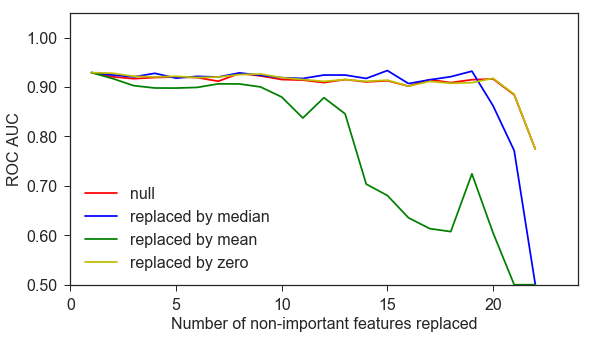

In [1633]:
def plot_feature_selection(n_median, roc_scores_median , n_mean, roc_scores_mean , n_zero, roc_scores_zero):
    fig = plt.figure(figsize=(20, 5))
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.plot(np.arange(22)+1, np.asarray(roc_scores_nan), c='r', label='null')
    ax2.plot(np.arange(22)+1, np.asarray(roc_scores_median), c='b', label='replaced by median')
    ax2.plot(np.arange(22)+1, np.asarray(roc_scores_mean), c='g', label='replaced by mean')
    ax2.plot(np.arange(22)+1, np.asarray(roc_scores_zero), c='y', label='replaced by zero')

    ax2.set_xlim(0, 24)
    ax2.set_ylim(0.5, 1.05)
    ax2.set_xlabel("Number of non-important features replaced")
    ax2.set_ylabel("ROC AUC")
    ax2.legend()
plot_feature_selection(n_median, roc_scores_median , n_mean, roc_scores_mean , n_zero, roc_scores_zero)

In [197]:
X_traintest_selected_cp.iloc[:, -4:].head()

,sum,sum_pos,sum_neg,disp
0,-2.350468,0.834237,-3.184705,-0.054348
1,-7.345422,0.673956,-8.019379,-0.160543
2,-0.445785,1.668060,-2.113845,-0.106963
3,-4.714061,0.658884,-5.372945,-0.100732
4,-1.911274,1.885572,-3.796846,-0.105462


In [1850]:
X_traintest_selected_cp = X_traintest_selected.copy()
X_valid_selected_cp = X_valid_selected.copy()

# X_traintest_selected_cp['sum'] = shap_traintest.sum(axis=1)
# X_traintest_selected_cp['sum_pos'] = shap_traintest[shap_traintest.gt(0, axis=1)].sum(axis=1)
# X_traintest_selected_cp['sum_neg'] = shap_traintest[shap_traintest.le(0, axis=1)].sum(axis=1)
# X_traintest_selected_cp['disp'] = shap_traintest.abs().var(axis=1)/ shap_traintest.sum(axis=1)

# X_valid_selected_cp['sum'] = shap_valid.sum(axis=1)
# X_valid_selected_cp['sum_pos'] = shap_valid[shap_valid.gt(0, axis=1)].sum(axis=1)
# X_valid_selected_cp['sum_neg'] = shap_valid[shap_valid.le(0, axis=1)].sum(axis=1)
# X_valid_selected_cp['disp'] = shap_valid.abs().var(axis=1)/shap_valid.sum(axis=1)

In [1857]:
# xgb_traintest_shap = xgboost.DMatrix(X_traintest_shap, label=y_traintest_sampled)
# xgb_valid_shap = xgboost.DMatrix(X_valid_shap, label=y_valid)

xgb_traintest_shap = xgboost.DMatrix(X_traintest_selected_cp[['C_083', 'N_046', 'N_045', 'N_152', 'N_143', 'N_138', 'N_136', 'C_224',
       'N_148', 'N_141', 'C_357', 'C_048', 'N_153', 'N_063']], label=y_traintest_sampled)
xgb_valid_shap = xgboost.DMatrix(X_valid_selected_cp[['C_083', 'N_046', 'N_045', 'N_152', 'N_143', 'N_138', 'N_136', 'C_224',
       'N_148', 'N_141', 'C_357', 'C_048', 'N_153', 'N_063']], label=y_valid)

In [1858]:
X_traintest_selected_cp.shape

(41550, 22)

In [1859]:
# use validation set to choose # of trees
params = {'max_depth':10, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2,
          'early_stopping_rounds':10
}

params['max_depth'] = 9
params['min_child_weight'] = 7
params['n_estimators'] = 100
params['subsample'] = 1.0
params['colsample_bytree'] = .7

In [1860]:
params

{'colsample_bytree': 0.7,
 'early_stopping_rounds': 10,
 'max_depth': 9,
 'min_child_weight': 7,
 'n_estimators': 100,
 'num_class': 2,
 'objective': 'multi:softmax',
 'subsample': 1.0}

In [1861]:
# X_traintest_selected_cp = X_traintest_selected.copy()
# X_valid_selected_cp = X_valid_selected.copy()
# xgb_traintest_test = xgboost.DMatrix(X_traintest_selected_cp, label=y_traintest_sampled)
# xgb_valid_test = xgboost.DMatrix(X_valid_selected_cp, label=y_valid)
xgb_shap = xgboost.train(params, xgb_traintest_shap, 100)

In [1862]:
evaluate_scores(xgb_valid_shap, y_valid, xgb_shap)

AUC score: 0.929
Accuracy score: 0.995
F1-micro score: 0.995
Cohen kappa score: 0.182
             precision    recall  f1-score   support

          0       1.00      0.99      1.00    598069
          1       0.10      0.86      0.18       409

avg / total       1.00      0.99      1.00    598478



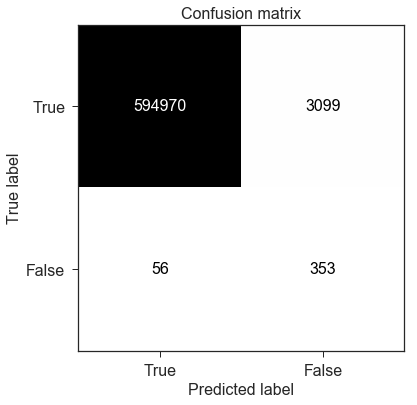

In [1863]:
confusion_matrix_plot(xgb_valid_shap, y_valid, xgb_shap)

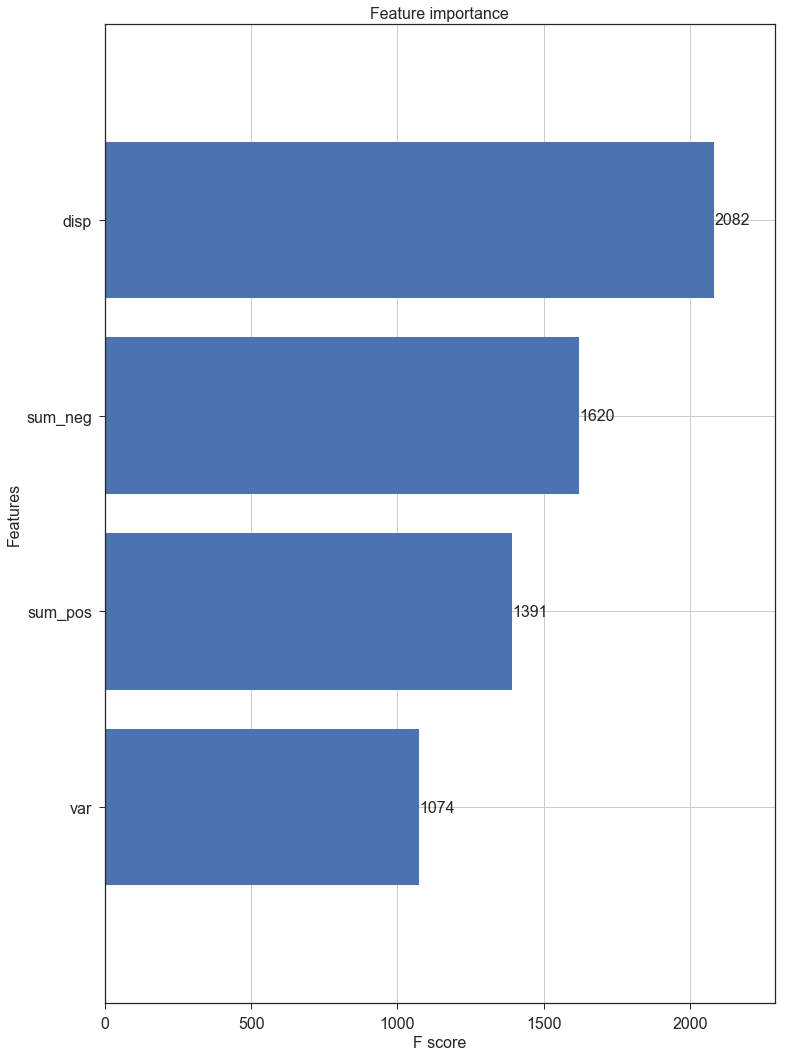

In [781]:
fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb_shap, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [ ]:
def plot_pr_roc_curve_scikit(clf, label, color, marker):
    pred = clf.predict(X_valid_selected)
    pred_prob = clf.predict_proba(X_valid_selected)[:,1]

    print("AUC score: {:.3f}".format(roc_auc_score(label, pred)))
#     print(classification_report(label, pred))
    print(confusion_matrix_plot(X_valid_selected, label, clf))
    
    precision, recall, thresholds_pr = precision_recall_curve(label, pred_prob)
    fpr, tpr, thresholds_roc = roc_curve(label, pred_prob)

    ax1.plot(recall, precision, c=color, label=par)
    ax2.plot(fpr, tpr, c=color, label=par)
    
    close_default_pr = np.argmin(np.abs(thresholds_pr - 0.5))
    close_default_roc = np.argmin(np.abs(thresholds_roc - 0.5))

    ax1.plot(recall[close_default_pr], precision[close_default_pr], marker=marker, markersize=12,
             fillstyle="none", c=color, mew=2)#, label=par)
    ax2.plot(fpr[close_default_roc], tpr[close_default_roc], marker=marker, markersize=12,
             fillstyle="none", c=color, mew=2, label=par)
    return ax1, ax2

In [ ]:
clf = XGBClassifier(learning_rate=0.3, objective='multi:softprob', num_class = 2, 
                           n_estimators=100, max_depth=9, colsample_bytree=0.7, 
                           min_child_weight=7, random_state=0)
clf.fit(X_traintest_selected_cp, y_traintest_sampled)


In [178]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def plot_roc_curve(clf, score, y, color, mark):
    pr_x = []
    pr_y = []
    
    roc_x = []
    roc_y = []
    min_score = min(score)
    max_score = max(score)
    thr = np.linspace(-0.13, 4.7681, 15)
#     thr = np.linspace(0.1,0.3, 3)
    FP=0
    TP=0
    P = sum(y)
    N = len(y) - P
    pr_x.append(1)
    pr_y.append(0)
    roc_x.append(1)
    roc_y.append(1)
    for (i, T) in enumerate(thr):
        for i in range(0, len(score)):
            if (score[i] > T):
                if (y[i]==1):
                    TP = TP + 1
                if (y[i]==0):
                    FP = FP + 1

        pr_x.append(safe_div(TP, P))
        if (safe_div(TP, float(P)) == 0):
            pr_y.append(1) 
        else:
            pr_y.append(safe_div(TP, (TP+FP)))

        roc_x.append(safe_div(FP, N))
        roc_y.append(safe_div(TP, P))
        print(P, N, TP, FP)
        print(roc_x, roc_y)
        FP=0
        TP=0
        
    if (np.min(pr_x) !=0):
        pr_x.append(0)
        pr_y.append(1)
        
    ax1.plot(pr_x, pr_y, c=color)
    ax2.plot(roc_x, roc_y, c=color)
    ax1.scatter(pr_x, pr_y, c=color)
    ax2.scatter(roc_x, roc_y, c=color)    
    
    for (i, T) in enumerate(thr):   
#         if (T==thres_mark):
        ax1.text(pr_x[i+1]+0.02, pr_y[i+1]+0.01, "{:.1f}".format(thr[i]), fontsize=12, color=color)
        ax2.text(roc_x[i+1]+0.02, roc_y[i+1]+0.01, "{:.1f}".format(thr[i]), fontsize=12, color=color)
    return ax1, ax2

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]
n=18, AUC-ROC score: 0.932, AUC score: 0

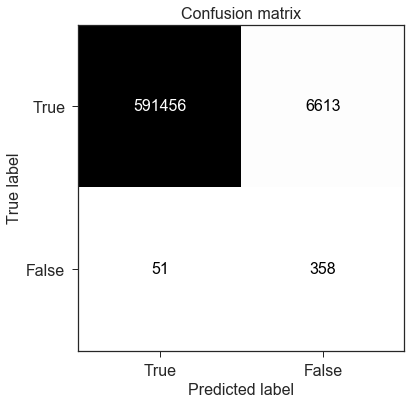

In [1877]:
n_remove = 18
n_test = []
roc_scores_test = []
X_traintest_selected_cp = X_traintest_selected.copy()
X_valid_selected_cp = X_valid_selected.copy()

for i in np.arange(n_remove):
    idx_min_traintest = np.argsort(X_traintest_shap.iloc[:, 0:22].abs().values)[:, i]
    idx_min_valid = np.argsort(X_valid_shap.iloc[:, 0:22].abs().values)[:, i]

    X_traintest_selected_cp.values[np.arange(len(idx_min_traintest)), idx_min_traintest] = "NAN"
    X_valid_selected_cp.values[np.arange(len(idx_min_valid)), idx_min_valid] = "NAN"
print(X_traintest_selected_cp.head())
# fillna with median
X_traintest_selected_cp.fillna(X_traintest_selected.copy().median(), inplace=True)
X_valid_selected_cp.fillna(X_valid_selected.copy().median(), inplace=True)
X_traintest_selected_cp.head()
# retrain the model
xgb_traintest_test = xgboost.DMatrix(X_traintest_selected_cp, label=y_traintest_sampled)
xgb_valid_test = xgboost.DMatrix(X_valid_selected_cp, label=y_valid)
xgb_test = xgboost.train(params, xgb_traintest_test, 100)
roc = roc_auc_score(y_valid, xgb_test.predict(xgb_valid_test))
accuracy = accuracy_score(y_valid, xgb_test.predict(xgb_valid_test))
print("n=%d, AUC-ROC score: %.3f, AUC score: %.3f"% (n_remove, roc, accuracy))
confusion_matrix_plot(xgb_valid_test, y_valid, xgb_test)

In [1879]:
n_remove = 18
n_test = []
roc_scores_test = []
X_traintest_selected_cp = X_traintest_selected.copy()
X_valid_selected_cp = X_valid_selected.copy()

for i in np.arange(n_remove):
    idx_min_traintest = np.argsort(X_traintest_shap.iloc[:, 0:22].abs().values)[:, i]
    idx_min_valid = np.argsort(X_valid_shap.iloc[:, 0:22].abs().values)[:, i]

    X_traintest_selected_cp.values[np.arange(len(idx_min_traintest)), idx_min_traintest] = "NAN"
    X_valid_selected_cp.values[np.arange(len(idx_min_valid)), idx_min_valid] = "NAN"
print(X_traintest_selected_cp.head())

   C_028  C_048  C_083  C_096  C_142  C_210  C_224  C_268  C_287  C_326  \
0    NaN    NaN  0.102    NaN  0.102    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN  0.102  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN  0.102    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN  0.100    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    N_046  N_063  N_130  N_136  N_138  N_141  N_143  N_148  N_152  N_153  
0  ...      NaN    NaN    NaN    NaN  0.154    NaN    NaN    NaN  0.131    NaN  
1  ...    0.102    NaN    NaN    NaN    NaN  0.139  0.134    NaN    NaN    NaN  
2  ...      NaN    NaN    NaN    NaN  0.140    NaN  0.128    NaN    NaN    NaN  
3  ...      NaN    NaN    NaN  0.157  0.155    NaN  0.141    NaN    NaN    NaN  
4  ...    0.114    NaN    NaN    NaN    NaN    NaN  0.100    NaN    NaN    NaN  

[5 rows x 22 columns]


In [1891]:
Counter(clf.predict(X_valid_selected_cp))

Counter({0: 594244, 1: 4234})

In [1889]:
predict_mine = np.where(xgb_pred> 0.9, 1, 0)
confusion_matrix(y_valid, predict_mine)

array([[594177,   3892],
       [    67,    342]])

409 598069 409 598069
[1, 1.0] [1, 1.0]
409 598069 342 3892
[1, 1.0, 0.006507610325898851] [1, 1.0, 0.8361858190709046]
409 598069 342 3892
[1, 1.0, 0.006507610325898851, 0.006507610325898851] [1, 1.0, 0.8361858190709046, 0.8361858190709046]
409 598069 342 3892
[1, 1.0, 0.006507610325898851, 0.006507610325898851, 0.006507610325898851] [1, 1.0, 0.8361858190709046, 0.8361858190709046, 0.8361858190709046]
409 598069 0 0
[1, 1.0, 0.006507610325898851, 0.006507610325898851, 0.006507610325898851, 0.0] [1, 1.0, 0.8361858190709046, 0.8361858190709046, 0.8361858190709046, 0.0]
409 598069 0 0
[1, 1.0, 0.006507610325898851, 0.006507610325898851, 0.006507610325898851, 0.0, 0.0] [1, 1.0, 0.8361858190709046, 0.8361858190709046, 0.8361858190709046, 0.0, 0.0]
409 598069 0 0
[1, 1.0, 0.006507610325898851, 0.006507610325898851, 0.006507610325898851, 0.0, 0.0, 0.0] [1, 1.0, 0.8361858190709046, 0.8361858190709046, 0.8361858190709046, 0.0, 0.0, 0.0]
409 598069 0 0
[1, 1.0, 0.006507610325898851, 0.006507610

(<matplotlib.axes._subplots.AxesSubplot at 0x1326d2ef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13298c940>)

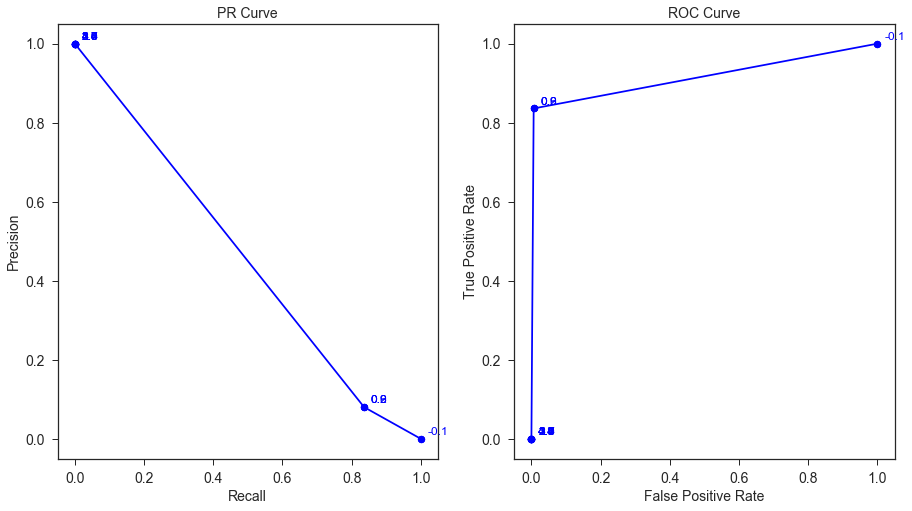

In [1880]:
clf = XGBClassifier(learning_rate=0.3, objective='multi:softprob', num_class = 2, 
                           n_estimators=100, max_depth=9, colsample_bytree=0.7, 
                           min_child_weight=7, random_state=0)
clf.fit(X_traintest_selected_cp, y_traintest_sampled)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 14})
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

# score = clf.predict_proba(X_valid_selected)[:,1]
plot_roc_curve(clf, clf.predict(X_valid_selected_cp), y_valid.values.flatten(), 'b', 'x')

In [127]:
select = SelectFromModel(
        XGBClassifier(n_estimators=500, random_state=0),
        threshold=str(2.45)+"*median")

select.fit(X_traintest_selected, np.array(y_traintest_sampled).ravel())
idxs_selected = select.get_support(indices=True)
X_traintest_selected_retrain = X_traintest_selected.iloc[:, idxs_selected]
X_traintest_selected_retrain.shape

(41550, 1)

In [2777]:
def feature_elimination(X_traintest_selected, X_valid_selected):
    features = np.linspace(X_traintest_selected.shape[1], 1, X_traintest_selected.shape[1])
    n_retrain = []
    roc_scores_retrain = []

    for n_features in features:
        select = RFE(RandomForestClassifier(n_estimators=100, random_state=0), n_features)
#         select = RFE(XGBClassifier(n_estimators=500, random_state=0), n_features)
        select.fit(X_traintest_selected, np.array(y_traintest_sampled).ravel())
        idxs_selected = select.get_support(indices=True)

        X_traintest_selected_retrain = X_traintest_selected.iloc[:, idxs_selected]
        X_valid_selected_retrain = X_valid_selected.iloc[:, idxs_selected]

        xgb_traintest_retrain = xgboost.DMatrix(X_traintest_selected_retrain, label=y_traintest_sampled)
        xgb_valid_retrain = xgboost.DMatrix(X_valid_selected_retrain, label=y_valid)
    
        selection_model = xgboost.train(params, xgb_traintest_retrain, 100)
        roc = roc_auc_score(y_valid, selection_model.predict(xgb_valid_retrain))
    
        roc_scores_retrain.append(roc)
        n_retrain.append(X_traintest_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_traintest_selected_retrain.shape[1], roc))
        print("The selected feature", X_traintest_selected_retrain.columns)

    return n_retrain, roc_scores_retrain

In [93]:
def feature_elimination_shap(X_traintest_shap, X_valid_shap):
    features = np.linspace(X_traintest_shap.shape[1], 1, X_traintest_shap.shape[1]).astype(int)
    n_shap = []
    roc_scores_shap = []
#     rank = X_traintest_selected.quantile(0.75, axis=0).rank()
    rank = X_traintest_shap.abs().mean().rank()
    X_traintest_shap_sorted = X_traintest_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_valid_shap_sorted = X_valid_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    

    for n_features in features:
        X_traintest_shap_retrain = X_traintest_shap_sorted.iloc[:, 0:n_features]
        X_valid_shap_retrain = X_valid_shap_sorted.iloc[:, 0:n_features]
        
        xgb_traintest_shap_retrain = xgboost.DMatrix(X_traintest_shap_retrain, label=y_traintest_sampled)
        xgb_valid_shap_retrain = xgboost.DMatrix(X_valid_shap_retrain, label=y_valid)
    
        selection_model = xgboost.train(params, xgb_traintest_shap_retrain, 100)
        roc = roc_auc_score(y_valid, selection_model.predict(xgb_valid_shap_retrain))

        roc_scores_shap.append(roc)
        n_shap.append(X_traintest_shap_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_traintest_shap_retrain.shape[1], roc))
        print("The selected feature", X_traintest_shap_retrain.columns)
    return n_shap, roc_scores_shap

In [47]:
def feature_elimination_shap_ori(X_traintest_shap, X_valid_shap):
    features = np.linspace(X_traintest_shap.shape[1], 1, X_traintest_shap.shape[1]).astype(int)
    n_shap_ori = []
    roc_scores_shap_ori = []
    rank = X_traintest_shap.abs().mean().rank()
    X_traintest_shap_sorted = X_traintest_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_valid_shap_sorted = X_valid_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
  
    ori_model = xgboost.train(params, xgb_traintest, 100)

    for n_features in features:
        X_traintest_shap_retrain = X_traintest_shap_sorted.iloc[:, 0:n_features]
        X_valid_shap_retrain = X_valid_shap_sorted.iloc[:, 0:n_features]
        
        xgb_traintest_shap_retrain = xgboost.DMatrix(X_traintest_shap_retrain, label=ori_model.predict(xgb_traintest))
        xgb_valid_shap_retrain = xgboost.DMatrix(X_valid_shap_retrain, label=ori_model.predict(xgb_valid))
    
        selection_model = xgboost.train(params, xgb_traintest_shap_retrain, 100)
        roc = roc_auc_score(ori_model.predict(xgb_valid), selection_model.predict(xgb_valid_shap_retrain))

        roc_scores_shap_ori.append(roc)
        n_shap_ori.append(X_traintest_shap_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_traintest_shap_retrain.shape[1], roc))
        print("The selected feature", X_traintest_shap_retrain.columns)
    return n_shap_ori, roc_scores_shap_ori

In [221]:
def feature_elimination_test(X_traintest_selected, X_valid_selected, X_traintest_shap, X_valid_shap):
    features = np.linspace(X_traintest_selected.shape[1], 1, X_traintest_selected.shape[1]).astype(int)
    n_retrain = []
    roc_scores_retrain = []
    rank = X_traintest_shap.abs().mean().rank()
    X_traintest_sorted = X_traintest_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_valid_sorted = X_valid_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_traintest_shap_sorted = X_traintest_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_valid_shap_sorted = X_valid_shap.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]
    
    for n_features in features:
        X_traintest_selected_retrain = X_traintest_sorted.iloc[:, 0:n_features]
        X_valid_selected_retrain = X_valid_sorted.iloc[:, 0:n_features]
        X_traintest_shap_retrain = X_traintest_shap_sorted.iloc[:, 0:n_features]
        X_valid_shap_retrain = X_valid_shap_sorted.iloc[:, 0:n_features]
        
        X_traintest_combine = X_traintest_selected_retrain.join(X_traintest_shap_retrain)
        X_valid_combine = X_valid_selected_retrain.join(X_valid_shap_retrain)
        
        xgb_traintest_retrain = xgboost.DMatrix(X_traintest_combine, label=y_traintest_sampled)
        xgb_valid_retrain = xgboost.DMatrix(X_valid_combine, label=y_valid)
    
        selection_model = xgboost.train(params, xgb_traintest_retrain, 100)
        roc = roc_auc_score(y_valid, selection_model.predict(xgb_valid_retrain))
    
        roc_scores_retrain.append(roc)
        n_retrain.append(X_traintest_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_traintest_combine.shape[1], roc))
        print("The selected feature", X_traintest_combine.columns)
        
    return n_retrain, roc_scores_retrain

In [2778]:
def feature_elimination_v2(X_traintest_selected, X_valid_selected, X_traintest_shap, X_valid_shap):
    features = np.linspace(X_traintest_selected.shape[1], 1, X_traintest_selected.shape[1]).astype(int)
    n_retrain = []
    roc_scores_retrain = []
    rank = X_traintest_shap.abs().mean().rank()
    X_traintest_sorted = X_traintest_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_valid_sorted = X_valid_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    print(X_traintest_sorted.head())
    for n_features in features:
        X_traintest_selected_retrain = X_traintest_sorted.iloc[:, 0:n_features]
        X_valid_selected_retrain = X_valid_sorted.iloc[:, 0:n_features]
        
        xgb_traintest_retrain = xgboost.DMatrix(X_traintest_selected_retrain, label=y_traintest_sampled)
        xgb_valid_retrain = xgboost.DMatrix(X_valid_selected_retrain, label=y_valid)
    
        selection_model = xgboost.train(params, xgb_traintest_retrain, 100)
        roc = roc_auc_score(y_valid, selection_model.predict(xgb_valid_retrain))
        accuracy = accuracy_score(y_valid, selection_model.predict(xgb_valid_retrain))

        roc_scores_retrain.append(roc)
        n_retrain.append(X_traintest_selected_retrain.shape[1])
        print("n=%d, AUC-ROC score: %.3f, AUC score: %.3f" % (X_traintest_selected_retrain.shape[1], roc, accuracy))
        print("The selected feature", X_traintest_selected_retrain.columns)
        
    return n_retrain, roc_scores_retrain

In [2779]:
n_retrain_v2, roc_scores_retrain_v2 = feature_elimination_v2(X_traintest_selected, X_valid_selected, shap_traintest.iloc[:, 0:22], shap_valid.iloc[:, 0:22])

   C_083  N_046  N_045  N_152  N_143  N_138  N_136  C_224  N_148  N_141  \
0  0.102  0.165  0.174  0.131  0.113  0.154  0.156    0.1  0.128  0.158   
1  0.102  0.102  0.102  0.145  0.134  0.134  0.138    0.1  0.128  0.139   
2  0.102  0.127  0.135  0.133  0.128  0.140  0.132    0.1  0.122  0.132   
3  0.102  0.159  0.168  0.144  0.141  0.155  0.157    0.1  0.144  0.158   
4  0.100  0.114  0.120  0.100  0.100  0.100  0.100    0.1  0.100  0.100   

   ...    N_153  N_063  N_130  C_142  C_028  C_287  C_326  C_210  C_096  C_268  
0  ...    0.196  0.165  0.113  0.102    0.1  0.100  0.102  0.101    0.1    0.1  
1  ...    0.999  0.102  0.130  0.100    0.1  0.100  0.102  0.101    0.1    0.1  
2  ...    0.177  0.127  0.128  0.100    0.1  0.102  0.102  0.102    0.1    0.1  
3  ...    0.999  0.159  0.141  0.100    0.1  0.100  0.102  0.101    0.1    0.1  
4  ...    0.999  0.114  0.100  0.100    0.1  0.100  0.100  0.101    0.1    0.1  

[5 rows x 22 columns]
n=22, AUC-ROC score: 0.919, AUC score: 0

In [ ]:
n_retrain_test, roc_scores_retrain_test = feature_elimination_test(X_traintest_selected, X_valid_selected, X_traintest_shap, X_valid_shap)

In [2780]:
n_retrain, roc_scores_retrain = feature_elimination(X_traintest_selected, X_valid_selected)

n=22, AUC score: 0.929
The selected feature Index(['C_028', 'C_048', 'C_083', 'C_096', 'C_142', 'C_210', 'C_224', 'C_268',
       'C_287', 'C_326', 'C_357', 'N_045', 'N_046', 'N_063', 'N_130', 'N_136',
       'N_138', 'N_141', 'N_143', 'N_148', 'N_152', 'N_153'],
      dtype='object')
n=21, AUC score: 0.916
The selected feature Index(['C_028', 'C_048', 'C_083', 'C_096', 'C_142', 'C_210', 'C_224', 'C_268',
       'C_287', 'C_357', 'N_045', 'N_046', 'N_063', 'N_130', 'N_136', 'N_138',
       'N_141', 'N_143', 'N_148', 'N_152', 'N_153'],
      dtype='object')
n=20, AUC score: 0.919
The selected feature Index(['C_028', 'C_048', 'C_083', 'C_096', 'C_210', 'C_224', 'C_268', 'C_287',
       'C_357', 'N_045', 'N_046', 'N_063', 'N_130', 'N_136', 'N_138', 'N_141',
       'N_143', 'N_148', 'N_152', 'N_153'],
      dtype='object')
n=19, AUC score: 0.921
The selected feature Index(['C_028', 'C_048', 'C_083', 'C_096', 'C_224', 'C_268', 'C_287', 'C_357',
       'N_045', 'N_046', 'N_063', 'N_130', 'N_

In [29]:
n_shap, roc_scores_shap = feature_elimination_shap(X_traintest_shap, X_valid_shap)

n=22, AUC score: 0.918
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHAP',
       'C_357_SHAP', 'C_048_SHAP', 'N_153_SHAP', 'N_063_SHAP', 'N_130_SHAP',
       'C_142_SHAP', 'C_028_SHAP', 'C_287_SHAP', 'C_326_SHAP', 'C_210_SHAP',
       'C_096_SHAP', 'C_268_SHAP'],
      dtype='object')
n=21, AUC score: 0.923
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHAP',
       'C_357_SHAP', 'C_048_SHAP', 'N_153_SHAP', 'N_063_SHAP', 'N_130_SHAP',
       'C_142_SHAP', 'C_028_SHAP', 'C_287_SHAP', 'C_326_SHAP', 'C_210_SHAP',
       'C_096_SHAP'],
      dtype='object')
n=20, AUC score: 0.920
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHA

In [44]:
n_shap_ori, roc_scores_shap_ori = feature_elimination_shap_ori(X_traintest_shap, X_valid_shap)

n=22, AUC score: 0.934
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHAP',
       'C_357_SHAP', 'C_048_SHAP', 'N_153_SHAP', 'N_063_SHAP', 'N_130_SHAP',
       'C_142_SHAP', 'C_028_SHAP', 'C_287_SHAP', 'C_326_SHAP', 'C_210_SHAP',
       'C_096_SHAP', 'C_268_SHAP'],
      dtype='object')
n=21, AUC score: 0.931
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHAP',
       'C_357_SHAP', 'C_048_SHAP', 'N_153_SHAP', 'N_063_SHAP', 'N_130_SHAP',
       'C_142_SHAP', 'C_028_SHAP', 'C_287_SHAP', 'C_326_SHAP', 'C_210_SHAP',
       'C_096_SHAP'],
      dtype='object')
n=20, AUC score: 0.934
The selected feature Index(['C_083_SHAP', 'N_046_SHAP', 'N_045_SHAP', 'N_152_SHAP', 'N_143_SHAP',
       'N_138_SHAP', 'N_136_SHAP', 'C_224_SHAP', 'N_148_SHAP', 'N_141_SHA

In [2782]:
def plot_feature_selection(n_retrain, roc_scores_retrain, n_retrain_v2, roc_scores_retrain_v2):#, n_shap_ori, roc_scores_shap_ori):
    fig = plt.figure(figsize=(20, 5))
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.plot(n_retrain, np.asarray(roc_scores_retrain), c='b', label='Original features vs Label')
    ax2.plot(n_retrain_v2, np.asarray(roc_scores_retrain_v2), c='y', label='Original features vs Label v2')
#     ax2.plot(n_shap, np.asarray(roc_scores_shap), c='r', label='SHAP features vs Label')
#     ax2.plot(n_shap_ori, np.asarray(roc_scores_shap_ori), c='g', label='SHAP features vs Original features')
#     ax2.plot(n_retrain_test, np.asarray(roc_scores_retrain_test), c='y', label='test')
#     ax2.plot(n_shap_ori, np.asarray(roc_scores_shap_ori), c='k', label='SHAP features+Original features')

    ax2.set_xlim(24, 0)
    ax2.set_ylim(0.5, 1.05)
    ax2.set_xlabel("Number of features")
    ax2.set_ylabel("ROC AUC")
    ax2.legend()

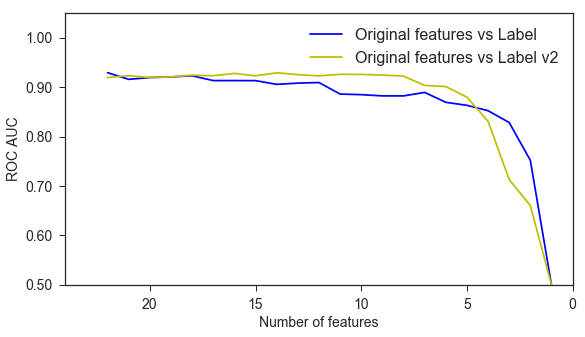

In [2783]:
plot_feature_selection(n_retrain, roc_scores_retrain, n_retrain_v2, roc_scores_retrain_v2)

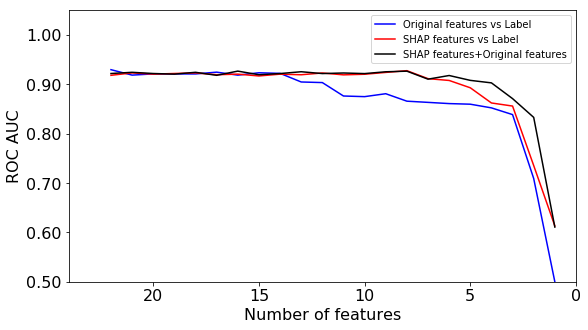

In [121]:
plot_feature_selection(n_retrain, roc_scores_retrain, n_shap, roc_scores_shap, n_retrain_test, roc_scores_retrain_test)

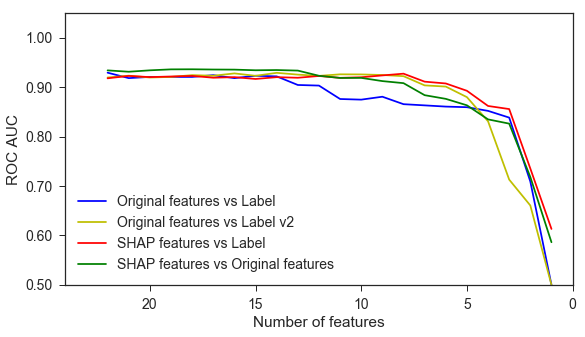

In [130]:
sns.set(style='ticks', font_scale=1.4)
plot_feature_selection(n_retrain, roc_scores_retrain, n_shap, roc_scores_shap, n_shap_ori, roc_scores_shap_ori)

In [32]:
select = SelectFromModel(
        XGBClassifier(n_estimators=500, random_state=0),
        threshold=str(0.9)+"*median") #RandomForestClassifier
select.fit(X_traintest_shap, np.array(y_traintest_sampled).ravel())
idxs_selected = select.get_support(indices=True)

X_traintest_shap_selected = X_traintest_shap.iloc[:, idxs_selected]
X_valid_shap_selected = X_valid_shap.iloc[:, idxs_selected]
# X_traintest_shap_selected.columns
selection_model.fit(X_traintest_shap_selected, np.array(y_traintest_sampled).ravel())
print("AUC score: {:.3f}".format(roc_auc_score(y_valid, selection_model.predict(X_valid_shap_selected))))


AUC score: 0.921


In [46]:
idx = np.argsort(np.abs(np.average(corr, axis=1)))[::-1]

In [475]:
def feature_selection(thresh, X_traintest_sampled, y_traintest_sampled, X_valid):
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]
    return X_traintest_selected, X_valid_selected

In [103]:
gridsearch_params = [
    (max_depth, min_child_weight, n_estimators, subsample, colsample)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
    for n_estimators in [100, 200, 500, 1000]
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

### LIME

In [11]:
# params['learning_rate'] = 0.3
# use validation set to choose # of trees
params = {'max_depth':10, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2,
          'early_stopping_rounds':10
#           'objective': 'binary:logistic'
}

params['max_depth'] = 9
params['min_child_weight'] = 7
params['n_estimators'] = 100
params['subsample'] = 1.0
params['colsample_bytree'] = .7
params

{'colsample_bytree': 0.7,
 'early_stopping_rounds': 10,
 'max_depth': 9,
 'min_child_weight': 7,
 'n_estimators': 100,
 'num_class': 2,
 'objective': 'multi:softmax',
 'subsample': 1.0}

In [12]:
scikit_xgb = XGBClassifier(learning_rate=0.3, objective='multi:softmax', num_class = 2, 
                           n_estimators=100, max_depth=9, colsample_bytree=0.7, 
                           min_child_weight=7)
# scikit_xgb.set_params(**params)

In [13]:
scikit_xgb.fit(X_traintest_selected,y_traintest_sampled)
evaluate_scores(X_valid_selected, y_valid, scikit_xgb)

AUC score: 0.929
Accuracy score: 0.995
F1-micro score: 0.995
Cohen kappa score: 0.199
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598069
          1       0.11      0.86      0.20       409

avg / total       1.00      1.00      1.00    598478



In [14]:
scikit_xgb.fit(np.array(X_traintest_selected), np.array(y_traintest_sampled))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=9, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=2, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_traintest_selected), 
                                                   feature_names=list(X_valid_selected),
                                                   class_names=['Not Mo1', 'Mo1'], discretize_continuous=False)

In [17]:
from time import sleep
import sys

lime_Mo1_valid = []
df = []
n=X_valid_selected.shape[0]
for i in range(X_valid_selected.shape[0]):
    sys.stdout.write('\r')
    exp = explainer.explain_instance(np.array(X_valid_selected)[i], scikit_xgb.predict_proba, num_features=22, top_labels=10)
#     exp.show_in_notebook(show_table=True, show_all=True)
    df = pd.DataFrame(np.array(exp.as_list()).T)
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])    
    if i == 0:
        lime_Mo1_valid = df
    else:
        lime_Mo1_valid = pd.concat([pd.DataFrame(lime_Mo1_valid), df], axis=0,).reset_index(drop=True)    

    j = (i + 1) / n
    sys.stdout.write("[%-20s] %f%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.25)

[====================] 100.000000%

In [19]:
lime_Mo1_valid.to_csv("lime_Mo1_valid.csv", sep='\t')

In [22]:
lime_Mo1_traintest = []
df = []
n=X_traintest_selected.shape[0]
for i in range(X_traintest_selected.shape[0]):
    sys.stdout.write('\r')
    exp = explainer.explain_instance(np.array(X_traintest_selected)[i], scikit_xgb.predict_proba, num_features=22, top_labels=10)
#     exp.show_in_notebook(show_table=True, show_all=True)
    df = pd.DataFrame(np.array(exp.as_list()).T)
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])    
    if i == 0:
        lime_Mo1_traintest = df
    else:
        lime_Mo1_traintest = pd.concat([pd.DataFrame(lime_Mo1_traintest), df], axis=0,).reset_index(drop=True)    

    j = (i + 1) / n
    sys.stdout.write("[%-20s] %f%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.05)

[====================] 100.000000%

In [17]:
shap_values_xgb_Mo1_valid['Condition'] = 'Cond'
shap_values_xgb_Mo1_valid.iloc[Mo1_tp, shap_values_xgb_Mo1_valid.columns.get_loc('Condition')] = 'TP'
shap_values_xgb_Mo1_valid.iloc[Mo1_fp, shap_values_xgb_Mo1_valid.columns.get_loc('Condition')] = 'FP'
shap_values_xgb_Mo1_valid.iloc[Mo1_fn, shap_values_xgb_Mo1_valid.columns.get_loc('Condition')] = 'FN'
shap_values_xgb_Mo1_valid.iloc[Mo1_tn, shap_values_xgb_Mo1_valid.columns.get_loc('Condition')] = 'TN'
shap_values_xgb_Mo1_valid['Sum'] = shap_values_xgb_Mo1_valid.iloc[:, 0:22].sum(axis=1)

In [20]:
shap_values_xgb_Mo1_valid['Condition'].value_counts()

TN    595301
FP      2768
TP       353
FN        56
Name: Condition, dtype: int64

In [21]:
Mo1_pos = []
Mo1_pos.extend(Mo1_tp)
Mo1_pos.extend(Mo1_fp)

In [22]:
X_valid_pos_shap = shap_values_xgb_Mo1_valid.iloc[Mo1_pos, :]
y_valid_pos = y_valid.iloc[Mo1_pos]
X_valid_pos_shap = X_valid_pos_shap.drop(['Condition'], 1)

In [23]:
xgb_pred_traintest = xgb.predict(xgb_traintest)

In [24]:
Mo1_tp_train = y_traintest_sampled.index[(y_traintest_sampled==1).iloc[:, 0] & (xgb_pred_traintest==1)].tolist()
Mo1_fp_train = y_traintest_sampled.index[(y_traintest_sampled==0).iloc[:, 0] & (xgb_pred_traintest==1)].tolist()
Mo1_tn_train = y_traintest_sampled.index[(y_traintest_sampled==0).iloc[:, 0] & (xgb_pred_traintest==0)].tolist()
Mo1_fn_train = y_traintest_sampled.index[(y_traintest_sampled==1).iloc[:, 0] & (xgb_pred_traintest==0)].tolist()

In [25]:
Mo1_pos_train = []
Mo1_pos_train.extend(Mo1_tp_train)
Mo1_pos_train.extend(Mo1_fp_train)

In [26]:
shap_values_xgb_Mo1_traintest['Condition'] = 'Cond'
shap_values_xgb_Mo1_traintest.iloc[Mo1_tp_train, shap_values_xgb_Mo1_traintest.columns.get_loc('Condition')] = 'TP'
shap_values_xgb_Mo1_traintest.iloc[Mo1_fp_train, shap_values_xgb_Mo1_traintest.columns.get_loc('Condition')] = 'FP'
shap_values_xgb_Mo1_traintest.iloc[Mo1_fn_train, shap_values_xgb_Mo1_traintest.columns.get_loc('Condition')] = 'FN'
shap_values_xgb_Mo1_traintest.iloc[Mo1_tn_train, shap_values_xgb_Mo1_traintest.columns.get_loc('Condition')] = 'TN'
shap_values_xgb_Mo1_traintest['Sum'] = shap_values_xgb_Mo1_traintest.iloc[:, 0:22].sum(axis=1)

In [27]:
X_traintest_pos_shap = shap_values_xgb_Mo1_traintest.iloc[Mo1_pos_train, :]
y_traintest_pos = y_traintest_sampled.iloc[Mo1_pos_train]
X_traintest_pos_shap = X_traintest_pos_shap.drop(['Condition'], 1)

In [86]:
from imblearn.over_sampling import SMOTE, RandomOverSampler 

r = 2
C = Counter(y_traintest_pos.fraud_label)
second_class = C.most_common(2)[-1][1]
major_class = C.most_common(1)[-1][1]
ratio={1: int(second_class*r)}

sm = RandomUnderSampler(random_state=0)#, ratio=ratio)
X_traintest_pos_sampled, y_traintest_pos_sampled = sm.fit_sample(X_traintest_pos_shap, 
                                                                  np.array(y_traintest_pos).ravel())
X_traintest_pos_sampled = pd.DataFrame(X_traintest_pos_sampled, columns=list(X_traintest_pos_shap))

In [96]:
shap_values_xgb_Mo1_traintest['Condition'].value_counts()

TN    39838
TP     1586
FN       70
FP       56
Name: Condition, dtype: int64

In [97]:
shap_values_xgb_Mo1_valid['Condition'].value_counts()

TN    595301
FP      2768
TP       353
FN        56
Name: Condition, dtype: int64

AUC score: 0.570
Accuracy score: 0.872
F1-micro score: 0.872
Cohen kappa score: 0.180
             precision    recall  f1-score   support

          0       0.90      0.96      0.93      2768
          1       0.37      0.18      0.24       353

avg / total       0.84      0.87      0.85      3121



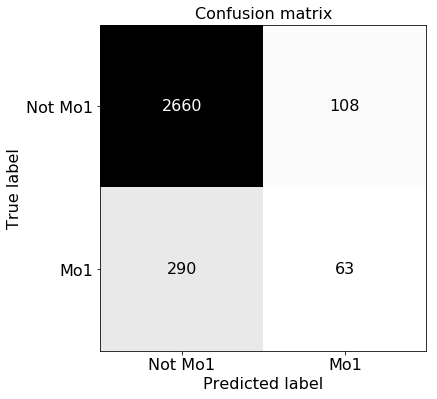

In [88]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_traintest_pos_sampled.iloc[:, [0]])  #2, 11, 12, 18, 20, 22
evaluate_scores(X_valid_pos_shap.iloc[:, [0]] , y_valid_pos, kmeans)
confusion_matrix_plot(X_valid_pos_shap.iloc[:, [0]] , y_valid_pos, kmeans)

In [90]:
xgb_traintest_pos_shap = xgboost.DMatrix(X_traintest_pos_sampled.iloc[:, [-1]], label=y_traintest_pos_sampled)
xgb_valid_pos_shap = xgboost.DMatrix(X_valid_pos_shap.iloc[:, [-1]], label=y_valid_pos)

In [91]:
params = {'max_depth':10, 'n_estimators':100,
          'objective': 'multi:softmax', 'num_class': 2,
          'early_stopping_rounds':10
#           'objective': 'binary:logistic'
}

In [92]:
xgb_pos_shap = xgboost.train(params, xgb_traintest_pos_shap, 100)

In [93]:
evaluate_scores(xgb_valid_pos_shap , y_valid_pos, xgb_pos_shap)
# evaluate_scores(X_valid_pos_shap.iloc[:, [6]] , y_valid_pos, kmeans)

AUC score: 0.701
Accuracy score: 0.666
F1-micro score: 0.666
Cohen kappa score: 0.194
             precision    recall  f1-score   support

          0       0.95      0.66      0.78      2768
          1       0.22      0.75      0.34       353

avg / total       0.87      0.67      0.73      3121



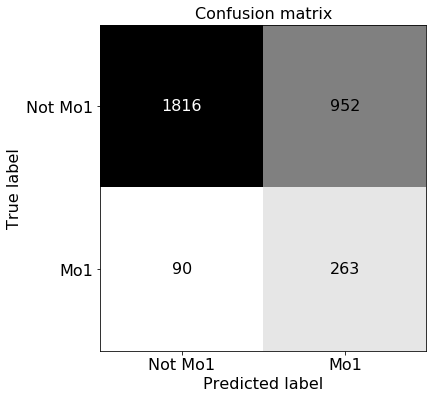

In [94]:
confusion_matrix_plot(xgb_valid_pos_shap , y_valid_pos, xgb_pos_shap)
# confusion_matrix_plot(X_traintest_pos_shap , y_traintest_pos, kmeans)

In [115]:
t1 = pd.read_csv('/Users/lillian/Documents/graduation_project/datasets/data_anoniem/2017Q3_valid-this.csv')

In [116]:
features = [28, 48, 83, 96, 142, 210, 224, 268, 287, 326, 357, 439, 440, 457, 524, 530, 532, 535, 537, 542, 546, 547]
f = [x+4 for x in features]

t1.iloc[:, f].describe()

,C_028,C_048,C_083,C_096,C_142,C_210,C_224,C_268,C_287,C_326,...,N_046,N_063,N_130,N_136,N_138,N_141,N_143,N_148,N_152,N_153
count,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,...,151095.000000,151095.000000,151095.000000,151095.00000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000,151095.000000
mean,0.100119,0.100968,0.101697,0.100023,0.100171,0.101061,0.100014,0.100023,0.100105,0.101953,...,0.132929,0.132929,0.137832,0.13381,0.134734,0.135659,0.142809,0.143016,0.138507,0.777814
std,0.001982,0.005734,0.000717,0.000215,0.000560,0.000244,0.000165,0.000215,0.000446,0.000302,...,0.021460,0.021460,0.020008,0.02273,0.022893,0.022992,0.025052,0.028026,0.095504,0.361751
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.173000
25%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.113000,0.113000,0.120000,0.11400,0.114000,0.115000,0.121000,0.123000,0.113000,0.196000
50%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.131000,0.131000,0.142000,0.13100,0.132000,0.133000,0.144000,0.145000,0.135000,0.999000
75%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.152000,0.152000,0.158000,0.15300,0.155000,0.156000,0.161000,0.163000,0.142000,0.999000
max,0.192000,0.160000,0.102000,0.102000,0.102000,0.106000,0.102000,0.102000,0.102000,0.102000,...,0.174000,0.174000,0.160000,0.95000,0.950000,0.179000,0.950000,0.950000,0.999000,0.999000


In [144]:
X_valid_pos_shap['quarter'] = 'quarter'
X_valid_pos_shap['quarter'].loc[((X_valid_pos_shap.index>=0) & (X_valid_pos_shap.index<151377))] = 'Q4'
X_valid_pos_shap['quarter'].loc[((X_valid_pos_shap.index>=151377) & (X_valid_pos_shap.index<151377+143592))] = 'Q1'
X_valid_pos_shap['quarter'].loc[((X_valid_pos_shap.index>=151377+143592) & (X_valid_pos_shap.index<151377+143592+152414))] = 'Q2'
X_valid_pos_shap['quarter'].loc[((X_valid_pos_shap.index>=151377+143592+152414) & (X_valid_pos_shap.index<151377+143592+152414+151095))] = 'Q3'

In [149]:
Counter(X_valid_pos_shap['quarter'])

Counter({'Q1': 750, 'Q2': 831, 'Q3': 690, 'Q4': 850})

In [79]:
print("TP max=",np.sum(shap_values_xgb_Mo1_tp[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_tp[:, 1, :], axis=1).min())
print("FP max=",np.sum(shap_values_xgb_Mo1_fp[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_fp[:, 1, :], axis=1).min())
print("FN max=",np.sum(shap_values_xgb_Mo1_fn[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_fn[:, 1, :], axis=1).min())
print("TN max=",np.sum(shap_values_xgb_Mo1_tn[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_tn[:, 1, :], axis=1).min())

TP max= 5.73518 min= 0.069911
FP max= 3.6476 min= -0.540122
FN max= 0.508991 min= -4.63483
TN max= -2.28543 min= -6.40206


In [8]:
def read_files(name):
    path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem' # use your path
    all_files = glob.glob(os.path.join(path, '*'+name+'.csv'))
    print('*'+name+'.csv')
    frame = pd.DataFrame()
    df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index(drop=True)
    return df

In [9]:
df_train_all = read_files('train')
df_test_all = read_files('test')
df_valid_all = read_files('valid-this')

*train.csv
*test.csv
*valid-this.csv


In [10]:
df_train_all['fraud_label'] = np.where((df_train_all['fraud_class'] == 'Mo1'), 1, 0)
df_test_all['fraud_label'] = np.where((df_test_all['fraud_class'] == 'Mo1'), 1, 0)
df_valid_all['fraud_label'] = np.where((df_valid_all['fraud_class'] == 'Mo1'), 1, 0)

In [11]:
X_train = df_train_all.iloc[:,4:-1]
y_train = df_train_all['fraud_label']
X_test = df_test_all.iloc[:,4:-1]
y_test = df_test_all['fraud_label']
X_valid = df_valid_all.iloc[:,4:-1]
y_valid = df_valid_all['fraud_label']

In [12]:
X = pd.concat((X_train, X_test, X_valid)).reset_index(drop=True)
y = pd.concat((pd.DataFrame(y_train), pd.DataFrame(y_test), pd.DataFrame(y_valid))).reset_index(drop=True)

In [83]:
y = y.fraud_label

In [14]:
params = {'max_depth':10, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2,
          'early_stopping_rounds':10
#           'objective': 'binary:logistic'
}

params['max_depth'] = 9
params['min_child_weight'] = 7
params['n_estimators'] = 100
params['subsample'] = 1.0
params['colsample_bytree'] = .7

In [89]:
def compute_errors_xgb(params):
    # Bootstraps
    n_repeat = 100
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)
    select_index = [28, 48, 83, 96, 142, 210, 224, 268, 287, 326, 357, 439, 
                    440, 457, 524, 530, 532, 535, 537, 542, 546, 547]
    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]
    X_selected = X.iloc[:, select_index]
    auc_scores = []
    f1_scores = []
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X_selected)):
        # Train and predict
        r = 30
        C = Counter(np.array(y.values.flatten()))
        second_class = C.most_common(2)[-1][1]
        major_class = C.most_common(1)[-1][1]
        ratio={0: int(major_class/r)}
        rus = RandomUnderSampler(random_state=0, ratio=ratio)
        X_train_sampled, y_train_sampled = rus.fit_sample(X_selected.iloc[train_index, :], 
                                                          y[train_index])
        X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_selected))
        X_test_selected = X_selected.iloc[test_index, :]

        clf = XGBClassifier(**params)
        clf.fit(X_train_sampled, y_train_sampled)
        y_pred = clf.predict(X_test_selected)
        auc = roc_auc_score(np.array(y[test_index]),
                            clf.predict(X_test_selected))
        f1 = f1_score(np.array(y[test_index]), clf.predict(X_test_selected), average="macro")
        auc_scores.append(auc)
        f1_scores.append(f1)
#         print("AUC score: {:.3f}".format(roc_auc_score(np.array(y[test_index]).astype(int), 
#                                                        clf.predict(X_selected.iloc[test_index, :]).astype(int))))   
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])
            
#     test =  ( i  for i,x in enumerate(y_all_pred) )
#     print(list(test))
    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])

    print("Bias squared: %.3f, Variance: %.3f, Total error: %.3f, Average AUC: %.3f, Average F1: %.3f" 
          % (bias_sq, var, error, np.array(auc_scores).mean(), np.array(f1_scores).mean()) )

In [90]:
compute_errors_xgb(params)

Bias squared: 1440.048, Variance: 414.352, Total error: 1854.400, Average AUC: 0.891, Average F1: 0.682
